# DATA3001 Yuumi Insurance EDA
Explore the insurance data with the aim of finding insights in the data (hypothetical company).

In this project, we were given log data for a hypothetical insurance company called Yuumi insurance. Yuumi insurance covers house and personal possessions against loss or damage caused by the following insured events: storm, fire, lightning, theft and escape of liquid. The insurance policy is priced according to the risk of the customer based off an array of information, done by actuaries within the “company”. Irrespective of the price of the insurance all policy has
a coverage of at most $25,000.

In this report, we will cover existing research on methods used to detect fraudulent customers. 

# Cleaning Data

The data given to us is in the format of a csv. There are 2 columns named message and tmestamp. The timestamp column contains values that are a float 64 data type, while the message columns contains values that are a string string data type. 

The goal of this code is the separate the message column into more defined columns, and create useful parameters from the timestamp and message columns.

With the purpose of detecting fraud in mind, we aim to separate each customer's interactions into useful parameters, with each customer's useful data being contained in one row, with each customer having a unique Id.


In [107]:
#package for cell runtime (dev only)
!pip install ipython-autotime
%load_ext autotime

# import basic libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
import os
%matplotlib inline

# preprocessing - encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from nltk.tokenize import WordPunctTokenizer
import json
from pandas.io.json import json_normalize
#json_normalize(msgLog['message'])

# make column width bigger when displaying columns
pd.set_option("display.max_colwidth", 1000)
# display more columns
pd.set_option("display.max_columns", None)
# format float display
pd.options.display.float_format = '{:.2f}'.format

#regex
import re

!pip install nameparser
from nameparser import HumanName

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.56 s


# Splitting the Message column

Each message row contains a unique transaction id, the device they made the transaction with, the action made by the customer, and a customer id.

In [108]:
log = pd.read_csv('Dataset/data.csv')

msgLog = pd.DataFrame()

#msgLog['message'] = log['message']
msgLog['transaction_id'], msgLog['device'], msgLog['message'] = log['message'].str.split('-',2).str
msgLog['action'], msgLog['message'] = msgLog['message'].str.split(':',1).str
msgLog['customer_id'], msgLog['message'] = msgLog['message'].str.split(n=1).str
msgLog['action'] = msgLog['action'].str.strip()

#msgLog['message'] = msgLog['message'].str.split('json payload',1).str[0]
msgLog['message'], msgLog['json_payload'] = msgLog['message'].str.split('json payload',1).str

msgLog['timestamp'] = log['timestamp']

# all transaction id's are unique, not very useful
# msgLog.transaction_id.value_counts()
msgLog = msgLog.drop(columns=['transaction_id'])

msgLog = msgLog.sort_values(by=['customer_id', 'timestamp'], kind = 'mergesort')
msgLog = msgLog.reset_index(drop=True)

# add paid dataframe to msgLog
paid = pd.DataFrame()
msgLog['message'], msgLog['paid'] = msgLog['message'].str.split('$').str
msgLog['paid'] = pd.to_numeric(msgLog['paid'])

time: 55.9 s


# Group by new id 

Group customers by new_id. Will do the following things:

1. merge with time df
2. then use the groupby function.
3. merge with paid_df

## get the min and max transaction time
Create data frames for minimum and maximum transaction times

In [109]:
oneHotAction = pd.DataFrame()
action = msgLog['action']
oneHotAction =  pd.get_dummies(action)
oneHotAction.columns = ['Cl_A', 'Cl_D', 'Cl_S', 'Pay_Comp', 'Pol_Canc', 'Q_C', 'Q_I', 'Q_S']
oneHotAction = oneHotAction[['Q_S', 'Q_C', 'Q_I', 'Cl_S', 'Cl_A', 'Cl_D', 'Pay_Comp', 'Pol_Canc']]
oneHotAction['customer_id'] = msgLog['customer_id']
oneHotAction['timestamp'] = msgLog['timestamp']
oneHotAction['no_actions'] = 1

# iterate through quote started column, create new id for each quote started
# note speed - fast cos only binary, slow cos 3 million rows

# checks for customer id changes, if customer id is same, checks for quote started
# cases to check for: (same customer id && new quote started)
# (action other than quote started occurs first after customer id change)

def create_new_id(quoteStarted, customerId):
    counter = -1
    array = []
    for i in range(0, len(quoteStarted)):
        if counter != -1:
            # different customer
            if customerId[i] != customerId[i-1]:
                counter += 1
                array.append(counter)
            elif quoteStarted[i] > 0:
                # repeated use of customer id in group
                if customerId[i] == customerId[i-1] and customerId[i] == customerId[i+1] and customerId[i] == customerId[i-2]:
                    counter += 1
                    array.append(counter)
                else:
                    array.append(counter)
            else:
                array.append(counter)
        else:
            counter += 1
            array.append(counter)
    return array

# create an arsray for the new id, note using vecttorise over np arrays method for speed
oneHotAction['new_id'] = create_new_id(oneHotAction.Q_S.values, oneHotAction.customer_id.values)

# expected minimum id is 0, maximim id is 632997 (= no of 1's in quote started - 1 as index starts from 0)
# note 621123 unique ids
#print(min(oneHotAction['new_id']),max(oneHotAction['new_id']))

# 14 edits to fix new ids as some quote started are after quotes completed
oneHotAction.at[[589335, 589336], 'new_id'] = 113198
oneHotAction.at[[709935, 709936], 'new_id'] = 136438
oneHotAction.at[[888762, 888763], 'new_id'] = 170509
oneHotAction.at[[938775, 938776], 'new_id'] = 180310
oneHotAction.at[[1795406, 1795407], 'new_id'] = 344095
oneHotAction.at[[2778333, 2778334], 'new_id'] = 532807
oneHotAction.at[[2938889, 2938890], 'new_id'] = 563504

def multiply_col_to_othercol(df, col):
    for i in range(0,len(df.columns)):
        df.iloc[:,i]=df.iloc[:,i]*col
    return df

quoteTimeDiff = pd.DataFrame()
quoteTimeDiff = pd.concat([quoteTimeDiff, oneHotAction['Q_C'], oneHotAction['Q_I'], oneHotAction['Q_S']], axis=1)
quoteTimeDiff = multiply_col_to_othercol(quoteTimeDiff, oneHotAction['timestamp'])
quoteTimeDiff = pd.concat([quoteTimeDiff, oneHotAction['new_id']], axis=1)
quoteTimeDiff = quoteTimeDiff.groupby(['new_id'], as_index = False).sum()
quoteTimeDiff = quoteTimeDiff.sort_values(by=['new_id'], kind = 'mergesort').reset_index(drop=True)

quoteTimeDiff['quote_time_diff'] = quoteTimeDiff[['Q_C', 'Q_S', 'Q_I']].sum(axis=1)
quoteTimeDiff['quote_time_diff'] = abs(quoteTimeDiff['quote_time_diff'] - 2*quoteTimeDiff['Q_S'])

oneHotAction = oneHotAction.sort_values(by=['new_id', 'timestamp'], kind = 'mergesort').reset_index(drop=True)

def time_difference(time, cid):
    difference = []
    first = 0
    # check if the current id is different to previous id, else get time difference
    for i in range(0, len(time)):
        if first == 0:
            difference.append(np.nan)
            first = 1
        elif cid[i] != cid[i-1]:
            difference.append(np.nan)
        else:
            difference.append(time[i] - time[i-1])  
    return difference

array = time_difference(oneHotAction.timestamp.values, oneHotAction.new_id.values)
oneHotAction['difference'] = array

minTime = pd.DataFrame()
minTime['min_trans_diff'], minTime['new_id'] = oneHotAction['difference'], oneHotAction['new_id']
# create mask
m = (minTime.reindex(minTime['min_trans_diff'].sort_values(ascending=True, na_position='last').index).duplicated(['new_id']))
# Apply inverted mask
minTime = minTime.loc[~m].sort_values(by=['new_id'], kind = 'mergesort').reset_index(drop=True)

maxTime = pd.DataFrame()
maxTime['max_trans_diff'], maxTime['new_id'] = oneHotAction['difference'], oneHotAction['new_id']

# create mask
m = (maxTime.reindex(maxTime['max_trans_diff'].sort_values(ascending=False, na_position='last').index).duplicated(['new_id']))
# Apply inverted mask
maxTime = maxTime.loc[~m].sort_values(by=['new_id'], kind = 'mergesort').reset_index(drop=True)

start = pd.DataFrame()
start['start'], start['new_id'] = oneHotAction['timestamp'], oneHotAction['new_id']

end = pd.DataFrame()
end['end'], end['new_id1'] = oneHotAction['timestamp'], oneHotAction['new_id']

# sort by new_id, then timestamp, asc and desc, get first value as 2 columns
m = (start.reindex(start['start'].sort_values(ascending=True).index).duplicated(['new_id']))
start = start.loc[~m]
start = start.reset_index(drop=True)

m = (end.reindex(end['end'].sort_values(ascending=False).index).duplicated(['new_id1']))
end = end.loc[~m]
end = end.reset_index(drop=True)

grouped = oneHotAction.groupby(['new_id'], as_index = False).sum()
grouped = grouped.sort_values(by=['new_id'], kind = 'mergesort').reset_index(drop=True)



time: 24.7 s


In [110]:
def encode_action_customer(value):
    return 1 if value > 0 else 0
# get payment complete times 

firstPayComp = pd.DataFrame()
firstPayComp = pd.concat([firstPayComp, oneHotAction['Pay_Comp']], axis=1)
# check that payment occurs only once (CONFIRMED)
# firstPayComp = pd.concat([firstPayComp, oneHotAction['Pay_Comp'], oneHotAction['new_id']], axis=1)
# firstPayComp = firstPayComp.groupby(['new_id'], as_index = False).sum()
# firstPayComp.Pay_Comp.value_counts()
firstPayComp = multiply_col_to_othercol(firstPayComp, oneHotAction['timestamp'])
firstPayComp = pd.concat([firstPayComp, oneHotAction['Pay_Comp'],oneHotAction['new_id']], axis=1)
firstPayComp = firstPayComp.groupby(['new_id'], as_index = False).sum()
firstPayComp.columns = ['new_id', 'Pay_Comp_times', 'Pay_Comp']

firstPayComp['Pay_Comp_encode'] = firstPayComp['Pay_Comp'].apply(encode_action_customer)

# get claim times 
claimTime = pd.DataFrame()
claimTime = pd.concat([claimTime, oneHotAction['Cl_S'], oneHotAction['Cl_D']], axis=1)
claimTime = multiply_col_to_othercol(claimTime, oneHotAction['timestamp'])
claimTime = pd.concat([claimTime, oneHotAction['Cl_S'], oneHotAction['Cl_D'], oneHotAction['new_id']], axis=1)
claimTime.columns = ['Cl_S_time', 'Cl_D_time', 'Cl_S', 'Cl_D', 'new_id']

claimGrouped = claimTime.groupby('new_id', as_index = False).sum()
claimGrouped['Cl_S_encode'] = claimGrouped['Cl_S'].apply(encode_action_customer)
claimGrouped['Cl_D_encode'] = claimGrouped['Cl_D'].apply(encode_action_customer)

claimTimeList = claimTime.groupby(['new_id'], as_index = False)['Cl_S_time'].apply(list)

claimGrouped['Cl_S_times_array'] = claimTimeList
claimGrouped['Pay_Comp_times'] = firstPayComp['Pay_Comp_times']
claimGrouped['Pay_Comp'] = firstPayComp['Pay_Comp']

# gets the first claim time of id, if there is no claim then set as nan
def get_first_claim(value):
    array = []
    for i in range(0, len(value)):
        #print(np.nonzero(value[i])[0])
        #print(np.nonzero(value[i])[0][0])
        #print(len(np.nonzero(value[i])[0]))
        if len(np.nonzero(value[i])[0]) > 0:
            array.append(value[i][np.nonzero(value[i])[0][0]])
        else:
            array.append(np.nan)
    return array

claimGrouped['Cl_S_time'] = get_first_claim(claimGrouped.Cl_S_times_array.values)
claimGrouped['claim_pay_diff'] = abs(claimGrouped['Cl_S_time'] - claimGrouped['Pay_Comp_times'])
claimGrouped = claimGrouped.drop(columns=['Cl_S_times_array'])

time: 34.8 s


In [111]:
time = pd.DataFrame()
time = pd.concat([grouped['new_id'], grouped['no_actions'], minTime['min_trans_diff'], maxTime['max_trans_diff'], start['start'], end['end'], claimGrouped['claim_pay_diff']], axis=1)
time['quote_time_diff'] = quoteTimeDiff['quote_time_diff']
time['total_trans_time'] = (time['end'] - time['start'])
time['mean_trans_time'] = (time['end'] - time['start'])/(time['no_actions']-1)
time = time.drop(columns = ['start', 'end'])
time = time[['new_id', 'no_actions', 'min_trans_diff', 'max_trans_diff', 'quote_time_diff', 'claim_pay_diff', 'mean_trans_time', 'total_trans_time']]

time: 105 ms


In [112]:
msgLog = pd.concat([msgLog, oneHotAction['new_id']], axis=1)
#fraud dataframe
fraud_col = pd.DataFrame()
fraud_col['message'], fraud_col['fraud'] = msgLog['message'].str.split('fraud').str

#one hot encode
fraud_col = pd.get_dummies(fraud_col, prefix_sep="", columns=['fraud'])

#merge fraud dataframe with msgLog
msgLog['fraud'] = fraud_col['fraud']

customer_fraud = msgLog[['new_id', 'fraud']]

#group fraudulent customers by 'customer_id' (probs a better method tbh)
fraudulent = customer_fraud.pivot_table(index=['new_id'], aggfunc=sum)
fraudulent['new_id1'] = fraudulent.index
fraudulent.index = range(fraudulent.shape[0])

#merge df: 'msgLog' and 'fraudulent' on 'customer_id'
merged = pd.merge(msgLog, fraudulent, left_on='new_id', right_on='new_id1', how='left').drop(['fraud_x', 'new_id1'], axis = 1)
merged = merged.rename(columns={'fraud_y': 'fraud'})
msgLog = merged

time: 10.8 s


In [113]:
msgLog.head()

,device,message,action,customer_id,json_payload,timestamp,paid,new_id,fraud
0,mobile_app,NaN,Quote Started for customer,000012,NaN,1520515553.72,nan,0,0
1,mobile_app,with,Quote Completed for customer,000012,"{'name': 'Kimberly Mathews', 'email': 'Kimberly Mathews@hotmail.com', 'gender': 'male', 'age': 53, 'home': {'type': 1, 'square_footage': 346.20595281589794, 'number_of_bedrooms': 5, 'number_of_floors': 1}, 'household': [{'name': 'Kristen Mathews', 'age': 14, 'gender': 'female'}, {'name': 'Randy Mathews', 'age': 9, 'gender': 'male'}], 'address': '16 Reidville, Richard Pine Suite '}",1520516303.52,nan,0,0
2,mobile_app,NaN,Quote Started for customer,000023,NaN,1496195647.93,nan,1,0
3,mobile_app,with,Quote Completed for customer,000023,"{'name': 'James Terrell', 'email': 'James Terrell@ryan-alvarado.com', 'gender': 'male', 'age': 30, 'home': {'type': 1, 'square_footage': 404.2134657047327, 'number_of_bedrooms': 2, 'number_of_floors': 1}, 'household': [], 'address': '114 Lake Matthewmouth,PSC '}",1496196488.27,nan,1,0
4,phone_call,NaN,Quote Started for customer,00003a,NaN,1496494950.52,nan,2,0


time: 6.99 ms


In [114]:
def payment_df(dataframe):
    
    """
    function to create a payment dataframe
    
    Shows new_id and min, max and avg payment for each new_id
    
    returns this payment dataframe
    """
    
    #create paid dataframe
    paid_df = dataframe[['new_id', 'paid']]

    #find min, max and avg payment for each new_id
    paid_df = paid_df.groupby('new_id')['paid'].agg([pd.np.min, pd.np.max, pd.np.mean])

    #rename col names for clarity
    paid_df = paid_df.rename(index=str, columns={'amin': 'paid_min', 'amax': 'paid_max', 'mean': 'paid_mean',})

    #create new_id col for merging later on
    paid_df['new_id'] = paid_df.index
    paid_df['new_id'] = paid_df['new_id'].astype(int)

    #rename index
    paid_df.index.names = ['']

    return paid_df

time: 1 ms


In [115]:
paid_df = payment_df(msgLog)
paid_df['paid_diff'] = abs(paid_df['paid_min'] - paid_df['paid_max'])
paid_df.head()

,paid_min,paid_max,paid_mean,new_id,paid_diff
,,,,,
0,nan,nan,nan,0,nan
1,nan,nan,nan,1,nan
2,5334.98,5334.98,5334.98,2,0.00
3,7972.84,7972.84,7972.84,3,0.00
4,nan,nan,nan,4,nan


time: 875 ms


In [116]:
#1. use the groupby function.
msgLog = msgLog.groupby(['device','json_payload','fraud'], as_index = False)[['new_id']].sum().sort_values(by=['new_id'])

#2. merge with time df
msgLog = pd.merge(msgLog, time, left_on='new_id', right_on='new_id', how='left')

#3. merge with paid_df
msgLog = pd.merge(msgLog, paid_df, left_on='new_id', right_on='new_id', how='left')
msgLog['address'] = np.nan

import warnings
warnings.filterwarnings('ignore')

warnings.filterwarnings('ignore')

def JSON_to_dataframe_regex(dataframe):
    
    """
    function that uses regex to read json payload and append it into a dataframe
    
    Needs to be cleaned up. Create a function cause this is repetitive. Also see caution.
    
    """

    #replace all single quotes with double quotes
    dataframe['json_payload'] = dataframe['json_payload'].apply(lambda text: np.nan if text is np.nan else text.replace("'", '"'))

    
    #holders
    #holder_name (string)
    dataframe['holder_name'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"name": ")(.*?)(?:")', text) is None) else re.findall('(?:"name": ")(.*?)(?:")', text)[0])

    #holder_email (string)
    dataframe['holder_email'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"email": ")(.*?)(?:")', text) is None) else re.findall('(?:"email": ")(.*?)(?:")', text)[0])

    #holder_gender (string)
    dataframe['holder_gender'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"gender": ")(.*?)(?:")', text) is None) else re.findall('(?:"gender": ")(.*?)(?:")', text)[0])

    #holder_age (numeric)
    dataframe['holder_age'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"age": )(\d+\.?\d*)', text) is None) else re.findall('(?:"age": )(\d+\.?\d*)', text)[0])


    #house
    #type (numeric)
    dataframe['house_type'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"type": )(\d+\.?\d*)', text) is None) else re.findall('(?:"type": )(\d+\.?\d*)', text)[0])

    #sqaure feet (numeric)
    dataframe['house_square_footage'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"square_footage": )(\d+\.?\d*)', text) is None) else re.findall('(?:"square_footage": )(\d+\.?\d*)', text)[0])

    #house_number_of_bedrooms (numeric)
    dataframe['house_number_of_bedrooms'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"number_of_bedrooms": )(\d+\.?\d*)', text) is None) else re.findall('(?:"number_of_bedrooms": )(\d+\.?\d*)', text)[0])

    #house_number_of_bedrooms (numeric)
    dataframe['house_number_of_floors'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"number_of_floors": )(\d+\.?\d*)', text) is None) else re.findall('(?:"number_of_floors": )(\d+\.?\d*)', text)[0])

    #address (string)
    dataframe['address'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"address": ")(.*?)(?:")', text) is None) else re.findall('(?:"address": ")(.*?)(?:")', text)[0])


    #occupants
    '''
    CAUTION:
    -------

    will not deal well with missing values as ages/genders in household are read in order

    eg.
    household : {[name:_____, gender:______], [name:______, age: 32, gender: _______]}

    Because there is no age entry for the 1st occupant- will think that the 1st occupant is 32 years old.
    '''

    #occupant_name
    dataframe['occupant_name'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"name": ")(.*?)(?:")', text) is None) else re.findall('(?:"name": ")(.*?)(?:")', text)[1:])

    #occupant_count
    
    dataframe['occupant_count'] = dataframe['json_payload'].apply(lambda text: 0 if (text is np.nan or re.search('(?:"name": ")(.*?)(?:")', text) is None) else len(re.findall('(?:"name": ")(.*?)(?:")', text)))
    
    #occupant_age
    dataframe['occupant_age'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"age": )(\d+\.?\d*)', text) is None) else re.findall('(?:"age": )(\d+\.?\d*)', text)[1:])

    #occupant_gender
    dataframe['occupant_gender'] = dataframe['json_payload'].apply(lambda text: np.nan if (text is np.nan or re.search('(?:"gender": ")(.*?)(?:")', text) is None) else re.findall('(?:"gender": ")(.*?)(?:")', text)[1:])
    
    return dataframe

#convert json to df (only takes ~1 minute LOL)
msgLog = JSON_to_dataframe_regex(msgLog)

#drop unnecessary columns
msgLog = msgLog.drop(columns=['json_payload'], axis = 1)

def first_name_last_name(dataframe):
    
    """
    function that converts a tuple of names into a tuple of first names and appends this column to the dataframe
    """

    #occupant
    dataframe['occupant_first_name'] = dataframe['occupant_name'].apply(lambda tuple1: np.nan if (tuple1 is np.nan or len(tuple1)==0) else ([HumanName(value)['first'] for value in tuple1]))
    #dataframe['occupant_last_name'] = dataframe['occupant_name'].apply(lambda tuple1: np.nan if (tuple1 is np.nan or len(tuple1)==0) else ([HumanName(value)['last'] for value in tuple1]))

    #holder
    dataframe['holder_first_name'] = dataframe['holder_name'].apply(lambda text: np.nan if (text is np.nan or len(text)==0) else (HumanName(text)['first']))
    #dataframe['holder_last_name'] = dataframe['holder_name'].apply(lambda text: np.nan if (text is np.nan or len(text)==0) else (HumanName(text)['last']))
    
    #drop names
    dataframe = dataframe.drop('occupant_name', axis = 1)
    dataframe = dataframe.drop('holder_name', axis = 1)
    
    return dataframe

msgLog = first_name_last_name(msgLog)

def seperate_address(dataframe):

    #find street, number and suburb from address column
    dataframe['street'] = dataframe['address'].apply(lambda text: np.nan if (text is np.nan or len(text)==0) else " ".join(text.split(',',2)[0].split()[1:]))
    dataframe['street_number'] = dataframe['address'].apply(lambda text: np.nan if (text is np.nan or len(text)==0) else text.split(',',2)[0].split()[0])
    dataframe['suburb'] = dataframe['address'].apply(lambda text: np.nan if (text is np.nan or len(text)==0) else text.split(',',2)[-1])

    #drop address
    dataframe = dataframe.drop('address', axis = 1)
    
    return dataframe

msgLog = seperate_address(msgLog)

def email_seperator(dataframe):
    
    #get email_prefix and provider
    dataframe['email_prefix'] = dataframe['holder_email'].apply(lambda text: np.nan if (text is np.nan or len(text)==0) else text.split('@',2)[0])
    dataframe['email_provider'] = dataframe['holder_email'].apply(lambda text: np.nan if (text is np.nan or len(text)==0) else "".join(text.split('@',2)[1:]))
    
    #drop email
    dataframe = dataframe.drop('holder_email', axis = 1)
    
    return dataframe

msgLog = email_seperator(msgLog)

time: 1min 18s


In [117]:
msgLog.head()

,device,fraud,new_id,no_actions,min_trans_diff,max_trans_diff,quote_time_diff,claim_pay_diff,mean_trans_time,total_trans_time,paid_min,paid_max,paid_mean,paid_diff,holder_gender,holder_age,house_type,house_square_footage,house_number_of_bedrooms,house_number_of_floors,occupant_count,occupant_age,occupant_gender,occupant_first_name,holder_first_name,street,street_number,suburb,email_prefix,email_provider
0,mobile_app,0,0,2,749.79,749.79,749.79,nan,749.79,749.79,nan,nan,nan,nan,male,53,1,346.20595281589794,5,1,3,"[14, 9]","[female, male]","[Kristen, Randy]",Kimberly,Reidville,16,Richard Pine Suite,Kimberly Mathews,hotmail.com
1,mobile_app,0,1,2,840.34,840.34,840.34,nan,840.34,840.34,nan,nan,nan,nan,male,30,1,404.2134657047327,2,1,1,[],[],NaN,James,Lake Matthewmouth,114,PSC,James Terrell,ryan-alvarado.com
2,phone_call,0,2,41,152.05,12309870.35,909.79,12309870.35,1264781.63,50591265.05,5334.98,5334.98,5334.98,0.00,female,33,0,173.39906418207295,2,1,3,"[9, 13]","[male, female]","[Jodi, Mary]",Bruce,North Danielborough,138,West Mountains Suite,Bruce Washington,yahoo.com
3,phone_call,0,3,24,106.50,2186081.22,727.67,31222.61,904472.77,20802873.74,7972.84,7972.84,7972.84,0.00,male,48,0,258.9137675110828,3,1,4,"[46, 9, 17]","[male, male, female]","[Clinton, Laura, Edward]",Keith,North Carolside,86,Taylor Mill,Keith Mendoza,holloway.com
4,pc_browser,0,4,2,773.41,773.41,773.41,nan,773.41,773.41,nan,nan,nan,nan,female,30,1,496.9237894372949,2,1,2,[31],[male],[Matthew],Daniel,Reidville,17,Barbara Circles,Daniel Murray,hotmail.com


time: 17 ms


In [118]:
#!pip install git+git://github.com/clintval/gender_predictor.git
from gender_predictor import GenderPredictor

#downloads files for local use
gp = GenderPredictor()
gp.train_and_test()

import complete
32,031 male names
56,347 female names
classifier accuracy: 97.08%
time: 3.77 s


In [119]:
def predicted_gender(dataframe):
    
    """
    function that uses genderpredictor to return a list of predicted genders for each occupant. 

    Used through df.apply for efficiency
    """

    #predict gender for occupants and holder
    dataframe['occupant_pred_gender'] = dataframe['occupant_first_name'].apply(lambda list1: np.nan if (list1 is np.nan or len(list1)==0) else [('' if value == '' else gp.classify(value)) for value in list1])
    dataframe['holder_pred_gender'] = dataframe['holder_first_name'].apply(lambda text: np.nan if (text is np.nan or len(text)==0) else gp.classify(text))
    
    '''
    #change actual gender from 'male' to 'M' (same for female)
    dataframe['occupant_gender'] = dataframe['occupant_gender'].apply(lambda list1: np.nan if (list1 is np.nan or len(list1)==0) else [('' if value == '' else value[0].upper()) for value in list1])
    dataframe['holder_gender'] = dataframe['holder_gender'].apply(lambda text: np.nan if (text is np.nan or len(text)==0) else text[0].upper())
    '''
    return dataframe

msgLog = predicted_gender(msgLog)

time: 29.9 s


# Encoding message

This section will:
1. encode all relevant data using label encoder or one hot encoding as appropriate - complete
2. Add (scaled) error between predicted gender and actual gender - complete

Encode stuff in tuples and list. 1 for male 0 for female. Will use self-made encoder.

In [120]:
def encode_nested_lists(dataframe):
    
    """
    function that allows for the encoding of nested lists

    Will use df.apply for efficiency
    
    male = 1
    female = 0
    M = 1
    F = 0
    """

    dataframe ['occupant_gender'] = dataframe['occupant_gender'].apply(lambda tuple1: np.nan if (tuple1 is np.nan or len(tuple1)==0) else [(1 if value == 'male' else 0) for value in tuple1])
    dataframe['occupant_pred_gender'] = dataframe['occupant_pred_gender'].apply(lambda list1: np.nan if (list1 is np.nan or len(list1)==0) else [(1 if value == 'M' else 0) for value in list1])

    return dataframe

msgLog = encode_nested_lists(msgLog)

def label_encode(dataframe, list_of_encoded_items):
    
    """
    function to label encode: 'holder_gender', 'holder_pred_gender', 'suburb', 'email_provider', 'device', 'street'
    
    Male = 1
    Female = 0
    M = 1
    F = 0
    """
    
    for i in list_of_encoded_items:
        dataframe[i] = LabelEncoder().fit_transform(dataframe[i])
    
    """
    dataframe['holder_gender'] = LabelEncoder().fit_transform(dataframe['holder_gender'])
    dataframe['holder_pred_gender'] = LabelEncoder().fit_transform(dataframe['holder_pred_gender'])
    dataframe['suburb'] = LabelEncoder().fit_transform(dataframe['suburb'])
    dataframe['email_provider'] = LabelEncoder().fit_transform(dataframe['email_provider'])

    dataframe['device'] = LabelEncoder().fit_transform(dataframe['device'])
    dataframe['street'] = LabelEncoder().fit_transform(dataframe['street'])
    """
    
    return dataframe

msgLog = label_encode(msgLog, ['holder_gender', 'holder_pred_gender', 'suburb', 'email_provider', 'device', 'street'])

time: 2.29 s


# Error in Gender
Find error in gender for each person and their occupants in their house

Error is defined as difference between predicted gender and actual gender. 

More details can be found in the code comments

In [121]:
def list_compare(list1, list2):
    
    """
    helper function to compare the values two lists
    
    creates another list of same length. If values are equal 0 is recorded else 1 is recorded. Then summed and divided by length.
    
    Eg. 
    list1 = [0,1,0,0]
    list2 = [0,0,0,0]
    
    returned_list = [0,1,0,0]
    returned_error = 1/4 = 0.25
    """
    
    #early exit
    if(len(list1)==0 or len(list2)==0):
        return 0
    
    #dealing with mismatching lengths (there's a hole in this method - that links to the caution mentioned above - but I ceebs making this code perfect)
    smallest = min(len(list1), len(list2))
    
    #new list
    list3 = []
    
    #print(len(list1))
    #print(len(list2))
    
    #loop through lists
    for i in range(smallest):
        
        #if not equal
        if(list1[i]!=list2[i]):
            list3.append(1)
            
        #if equal
        else:
            list3.append(0)
            
    #print(sum(list3))
    #print(len(list3))
    #print(list3)
    
    return sum(list3)/len(list3)

def gender_error(dataframe):
    
    """
    driver function to find the error between predicted gender and actual gender for both occupants and holders
    """
    
    dataframe['holder_error_in_gender'] = abs(dataframe['holder_gender'] - msgLog['holder_pred_gender'])
    dataframe['occupant_error_in_gender'] = dataframe.apply(lambda row: np.nan if (row['occupant_gender'] is np.nan or len(row['occupant_gender'])==0) else list_compare(row['occupant_gender'], row['occupant_pred_gender']), axis = 1)

    return dataframe

msgLog = gender_error(msgLog)

time: 26.7 s


# Occupant Age

get min, max and avg age for occupants

In [122]:
from statistics import mean

def breakdown_occupant_age(dataframe):

    dataframe['occupant_age'] = dataframe['occupant_age'].apply(lambda list1: np.nan if (list1 is np.nan or len(list1)==0) else ([int(i) for i in list1]))

    dataframe['mean_occupant_age'] = dataframe['occupant_age'].apply(lambda list1: 0 if (list1 is np.nan or len(list1)==0) else (mean(list1)))

    dataframe['min_occupant_age'] = dataframe['occupant_age'].apply(lambda list1: 0 if (list1 is np.nan or len(list1)==0) else (min(list1)))

    dataframe['max_occupant_age'] = dataframe['occupant_age'].apply(lambda list1: 0 if (list1 is np.nan or len(list1)==0) else (max(list1)))
    
    dataframe['sum_occupant_age'] = dataframe['occupant_age'].apply(lambda list1: 0 if (list1 is np.nan or len(list1)==0) else (sum(list1)))
    
    
    #dataframe = dataframe.drop('occupant_age', axis = 1)
    
    return dataframe
msgLog = breakdown_occupant_age(msgLog)

time: 6.44 s


In [123]:
msgLog.head()

,device,fraud,new_id,no_actions,min_trans_diff,max_trans_diff,quote_time_diff,claim_pay_diff,mean_trans_time,total_trans_time,paid_min,paid_max,paid_mean,paid_diff,holder_gender,holder_age,house_type,house_square_footage,house_number_of_bedrooms,house_number_of_floors,occupant_count,occupant_age,occupant_gender,occupant_first_name,holder_first_name,street,street_number,suburb,email_prefix,email_provider,occupant_pred_gender,holder_pred_gender,holder_error_in_gender,occupant_error_in_gender,mean_occupant_age,min_occupant_age,max_occupant_age,sum_occupant_age
0,0,0,0,2,749.79,749.79,749.79,nan,749.79,749.79,nan,nan,nan,nan,1,53,1,346.20595281589794,5,1,3,"[14, 9]","[0, 1]","[Kristen, Randy]",Kimberly,56,16,358,Kimberly Mathews,39602,"[1, 0]",0,1,1.00,11.50,9,14,23
1,0,0,1,2,840.34,840.34,840.34,nan,840.34,840.34,nan,nan,nan,nan,1,30,1,404.2134657047327,2,1,1,NaN,NaN,NaN,James,32,114,467,James Terrell,76841,NaN,1,0,nan,0.00,0,0,0
2,3,0,2,41,152.05,12309870.35,909.79,12309870.35,1264781.63,50591265.05,5334.98,5334.98,5334.98,0.00,0,33,0,173.39906418207295,2,1,3,"[9, 13]","[1, 0]","[Jodi, Mary]",Bruce,48,138,447,Bruce Washington,96875,"[0, 0]",0,0,0.50,11.00,9,13,22
3,3,0,3,24,106.50,2186081.22,727.67,31222.61,904472.77,20802873.74,7972.84,7972.84,7972.84,0.00,1,48,0,258.9137675110828,3,1,4,"[46, 9, 17]","[1, 1, 0]","[Clinton, Laura, Edward]",Keith,47,86,411,Keith Mendoza,38969,"[1, 0, 1]",1,0,0.67,24.00,9,46,72
4,2,0,4,2,773.41,773.41,773.41,nan,773.41,773.41,nan,nan,nan,nan,0,30,1,496.9237894372949,2,1,2,[31],[1],[Matthew],Daniel,56,17,18,Daniel Murray,39602,[1],1,1,0.00,31.00,31,31,31


time: 20 ms


In [124]:
def convert_cols_to_nuermic(dataframe, list_of_cols_to_fix):
    
    """
    function to fix an issue that shouldn't occur in the first place
    """
    
    for i in list_of_cols_to_fix:
        dataframe[i] = dataframe[i].astype(float)
        
    return dataframe
        
msgLog = convert_cols_to_nuermic(msgLog, ['house_square_footage', 'holder_age', 'house_type', 'house_number_of_bedrooms', 'house_number_of_floors', 'street_number', 'occupant_count'])                                   

time: 1.25 s


In [125]:
msgLog['mean_household_age'] = (msgLog['sum_occupant_age'] + msgLog['holder_age'])/msgLog['occupant_count']

time: 8 ms


In [126]:
msgLog2 = msgLog.copy()

time: 509 ms


In [127]:
msgLog.head()

,device,fraud,new_id,no_actions,min_trans_diff,max_trans_diff,quote_time_diff,claim_pay_diff,mean_trans_time,total_trans_time,paid_min,paid_max,paid_mean,paid_diff,holder_gender,holder_age,house_type,house_square_footage,house_number_of_bedrooms,house_number_of_floors,occupant_count,occupant_age,occupant_gender,occupant_first_name,holder_first_name,street,street_number,suburb,email_prefix,email_provider,occupant_pred_gender,holder_pred_gender,holder_error_in_gender,occupant_error_in_gender,mean_occupant_age,min_occupant_age,max_occupant_age,sum_occupant_age,mean_household_age
0,0,0,0,2,749.79,749.79,749.79,nan,749.79,749.79,nan,nan,nan,nan,1,53.00,1.00,346.21,5.00,1.00,3.00,"[14, 9]","[0, 1]","[Kristen, Randy]",Kimberly,56,16.00,358,Kimberly Mathews,39602,"[1, 0]",0,1,1.00,11.50,9,14,23,25.33
1,0,0,1,2,840.34,840.34,840.34,nan,840.34,840.34,nan,nan,nan,nan,1,30.00,1.00,404.21,2.00,1.00,1.00,NaN,NaN,NaN,James,32,114.00,467,James Terrell,76841,NaN,1,0,nan,0.00,0,0,0,30.00
2,3,0,2,41,152.05,12309870.35,909.79,12309870.35,1264781.63,50591265.05,5334.98,5334.98,5334.98,0.00,0,33.00,0.00,173.40,2.00,1.00,3.00,"[9, 13]","[1, 0]","[Jodi, Mary]",Bruce,48,138.00,447,Bruce Washington,96875,"[0, 0]",0,0,0.50,11.00,9,13,22,18.33
3,3,0,3,24,106.50,2186081.22,727.67,31222.61,904472.77,20802873.74,7972.84,7972.84,7972.84,0.00,1,48.00,0.00,258.91,3.00,1.00,4.00,"[46, 9, 17]","[1, 1, 0]","[Clinton, Laura, Edward]",Keith,47,86.00,411,Keith Mendoza,38969,"[1, 0, 1]",1,0,0.67,24.00,9,46,72,30.00
4,2,0,4,2,773.41,773.41,773.41,nan,773.41,773.41,nan,nan,nan,nan,0,30.00,1.00,496.92,2.00,1.00,2.00,[31],[1],[Matthew],Daniel,56,17.00,18,Daniel Murray,39602,[1],1,1,0.00,31.00,31,31,31,30.50


time: 19 ms


# Cleaning final dataframe

In [128]:
msgLog = msgLog.drop(['occupant_first_name', 'holder_first_name', 'email_prefix', 'occupant_pred_gender', 'occupant_gender', 'occupant_age'], axis = 1)

def set_to_numbers(dataframe, list_of_cols_to_fix):
    
    """
    function to fix an issue that shouldn't occur in the first place
    """
    
    for i in list_of_cols_to_fix:
        dataframe[i] = dataframe[i].astype(float)
        
    return dataframe
        
msgLog = set_to_numbers(msgLog, ['house_square_footage', 'holder_age', 'house_type', 'house_number_of_bedrooms', 'house_number_of_floors', 'street_number'])

time: 109 ms


In [129]:
#msgLog.to_csv('df_unfilled_nan_extra_cols.csv.csv',index = False)
#os.getcwd()

Error in callback <function LineWatcher.stop at 0x0000016B8D3948C8> (for post_run_cell):


AssertionError: 

In [130]:
msgLog.head()

,device,fraud,new_id,no_actions,min_trans_diff,max_trans_diff,quote_time_diff,claim_pay_diff,mean_trans_time,total_trans_time,paid_min,paid_max,paid_mean,paid_diff,holder_gender,holder_age,house_type,house_square_footage,house_number_of_bedrooms,house_number_of_floors,occupant_count,street,street_number,suburb,email_provider,holder_pred_gender,holder_error_in_gender,occupant_error_in_gender,mean_occupant_age,min_occupant_age,max_occupant_age,sum_occupant_age,mean_household_age
0,0,0,0,2,749.79,749.79,749.79,nan,749.79,749.79,nan,nan,nan,nan,1,53.00,1.00,346.21,5.00,1.00,3.00,56,16.00,358,39602,0,1,1.00,11.50,9,14,23,25.33
1,0,0,1,2,840.34,840.34,840.34,nan,840.34,840.34,nan,nan,nan,nan,1,30.00,1.00,404.21,2.00,1.00,1.00,32,114.00,467,76841,1,0,nan,0.00,0,0,0,30.00
2,3,0,2,41,152.05,12309870.35,909.79,12309870.35,1264781.63,50591265.05,5334.98,5334.98,5334.98,0.00,0,33.00,0.00,173.40,2.00,1.00,3.00,48,138.00,447,96875,0,0,0.50,11.00,9,13,22,18.33
3,3,0,3,24,106.50,2186081.22,727.67,31222.61,904472.77,20802873.74,7972.84,7972.84,7972.84,0.00,1,48.00,0.00,258.91,3.00,1.00,4.00,47,86.00,411,38969,1,0,0.67,24.00,9,46,72,30.00
4,2,0,4,2,773.41,773.41,773.41,nan,773.41,773.41,nan,nan,nan,nan,0,30.00,1.00,496.92,2.00,1.00,2.00,56,17.00,18,39602,1,1,0.00,31.00,31,31,31,30.50


time: 13 ms


In [131]:
# reordering the table
msgLog = msgLog[['new_id', 'fraud', 'device', 'no_actions', 'min_trans_diff', 'max_trans_difference', 'quote_time_difference', 'claim_pay_difference', 'mean_trans_time', 'total_trans_time', 'paid_min', 'paid_max', 'paid_mean', 'paid_difference', 'occupant_count', 'holder_gender', 'holder_age', 'holder_error_in_gender', 'occupant_error_in_gender', 'min_occupant_age', 'max_occupant_age', 'mean_occupant_age', 'mean_household_age', 'house_type', 'house_square_footage', 'house_number_of_bedrooms', 'house_number_of_floors', 'street', 'street_number','suburb', 'email_provider']]

KeyError: "['max_trans_difference', 'paid_difference', 'quote_time_difference', 'claim_pay_difference'] not in index"

time: 10 ms


In [ ]:
msgLog.head()

# Data Modelling

Methods used:
- Logistic regresion
- KNN
- XGBOOST


In [143]:
#data visualisation
import seaborn as sns
sns.set(font_scale=2)
plt.style.use('seaborn-whitegrid')
import warnings
warnings.simplefilter('ignore')
# preprocessing - encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from nltk.tokenize import WordPunctTokenizer
import json
from pandas.io.json import json_normalize
#json_normalize(msgLog['message'])
# make column width bigger when displaying columns
pd.set_option("display.max_colwidth", 1000)
# display more columns
pd.set_option("display.max_columns", None)
# format float display
pd.options.display.float_format = '{:.2f}'.format

#libraries
import re
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import xgboost as xgb
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score,roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold


time: 3 ms


In [144]:
# # Read Data from CSV
# read data from part 1 into msgLog

msgLog = pd.read_csv('df_unfilled_nan_extra_cols.csv')

def fill_na(dataframe, list_of_cols):
    for col in list_of_cols:
        dataframe[col] = dataframe[col].fillna(0)
    return dataframe
msgLog = fill_na(msgLog, ['paid_min', 'paid_max', 'paid_mean','house_square_footage', 'house_number_of_bedrooms','house_number_of_floors', 'claim_pay_diff', 'paid_diff', 'occupant_error_in_gender'])

time: 1.31 s


In [145]:
# # Graphs
# graphs to get an idea of the data

def bar_plot(count, title):
    
    """
    function that creates bar plot from value_counts of variable. Just makes graphing easier.
    """
    
    x = count.index
    y = count.values
    plt.figure(figsize=(10,5))
    sns.barplot(x,y,palette='rocket')
    plt.title(title)
    
def bar_plot_horizontal(count, title):
    
    """
    function that creates a horizontal bar plot from value_counts of variable. Just makes graphing easier.
    """
    
    y = count.index
    x = count.values
    plt.figure(figsize=(20,10))
    b = sns.barplot(x,y,palette='rocket')
    plt.title(title)

time: 1 ms


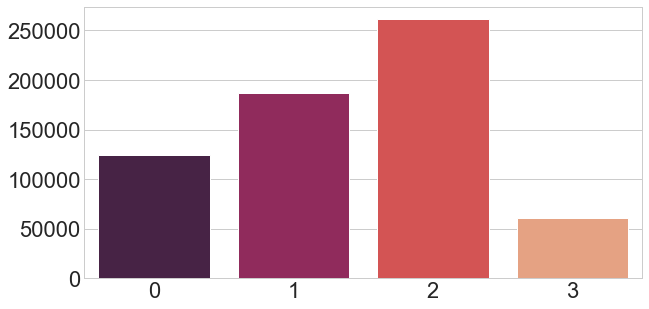

time: 144 ms


In [146]:
bar_plot(msgLog['device'].value_counts(ascending = True), '')

([<matplotlib.axis.XTick at 0x16def3df6d8>,
 <a list of 2 Text xticklabel objects>)

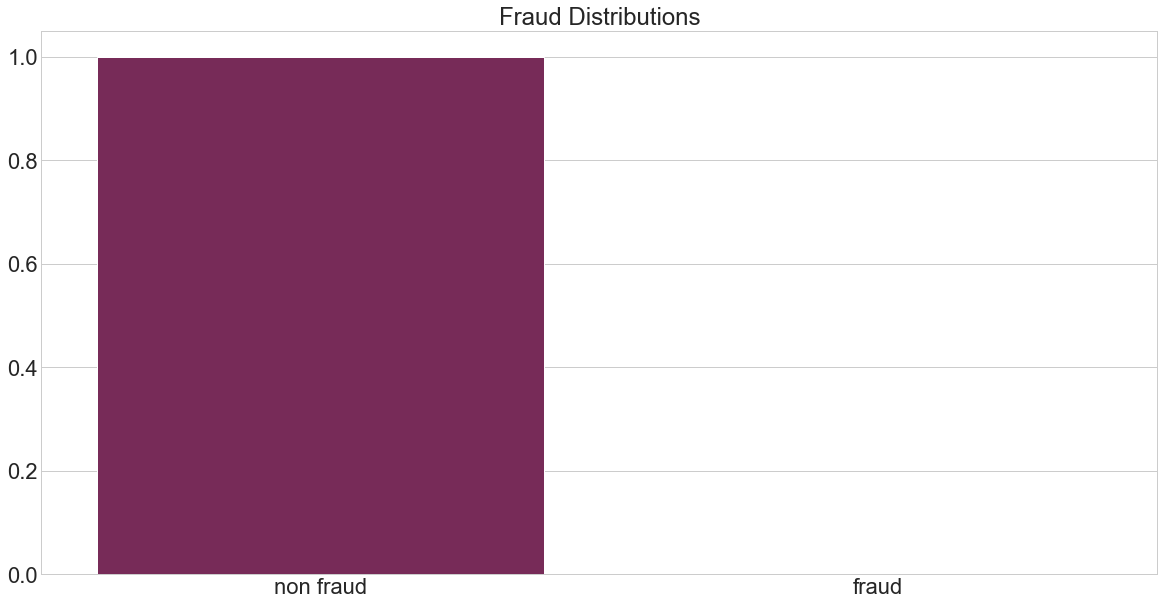

time: 154 ms


In [147]:
y = msgLog['fraud'].value_counts(ascending = True).index
x = msgLog['fraud'].value_counts(ascending = True).values
plt.figure(figsize=(20,10))
b = sns.barplot(x,y,palette='rocket')
plt.title('Fraud Distributions')
plt.xticks(np.arange(2), ['non fraud', 'fraud' ])
# Analysing only the fraudulent customers

In [148]:

#fraudulent customers only
fraud_df = msgLog[msgLog['fraud'] == 1]
fraud_df.index = range(fraud_df.shape[0])
fraud_df.head()
len(fraud_df)

10494

time: 14 ms


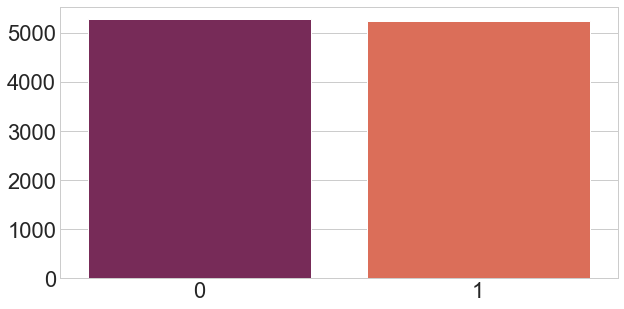

time: 81 ms


In [149]:
#graph of males and females
bar_plot(fraud_df['holder_gender'].value_counts(ascending = True), "")

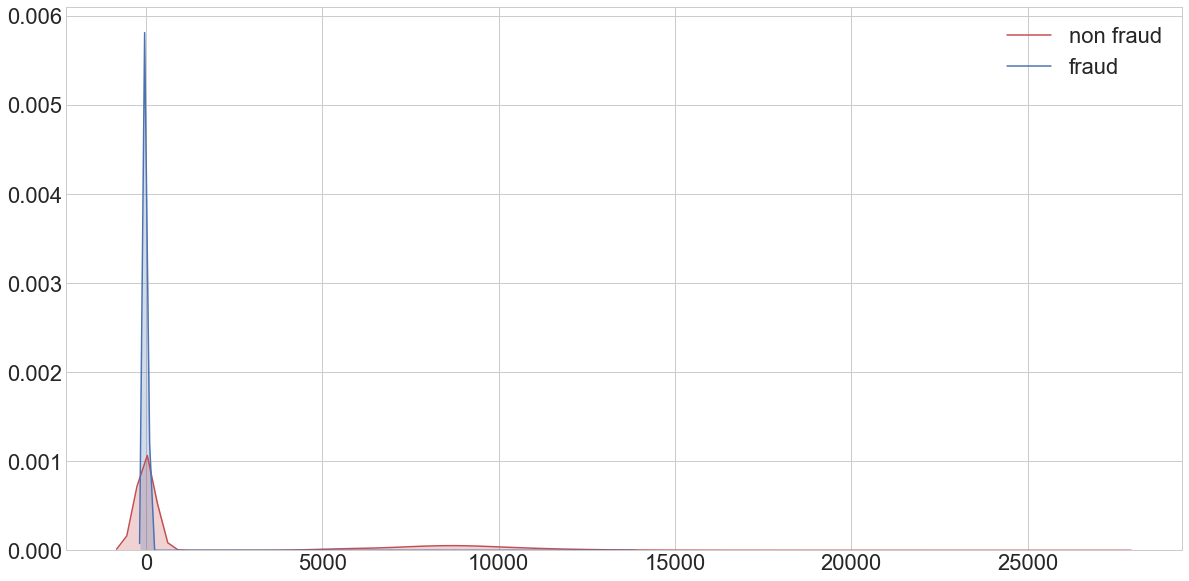

time: 3.41 s


In [151]:

non_fraud_df = msgLog[msgLog['fraud']==0]
# plot of 2 variables
plt.figure(figsize=(20,10))
p1=sns.kdeplot(non_fraud_df['paid_max'], shade=True, color="r", label = 'non fraud')
p1=sns.kdeplot(fraud_df['paid_max'], shade=True, color="b", label = 'fraud')
#sns.plt.show()

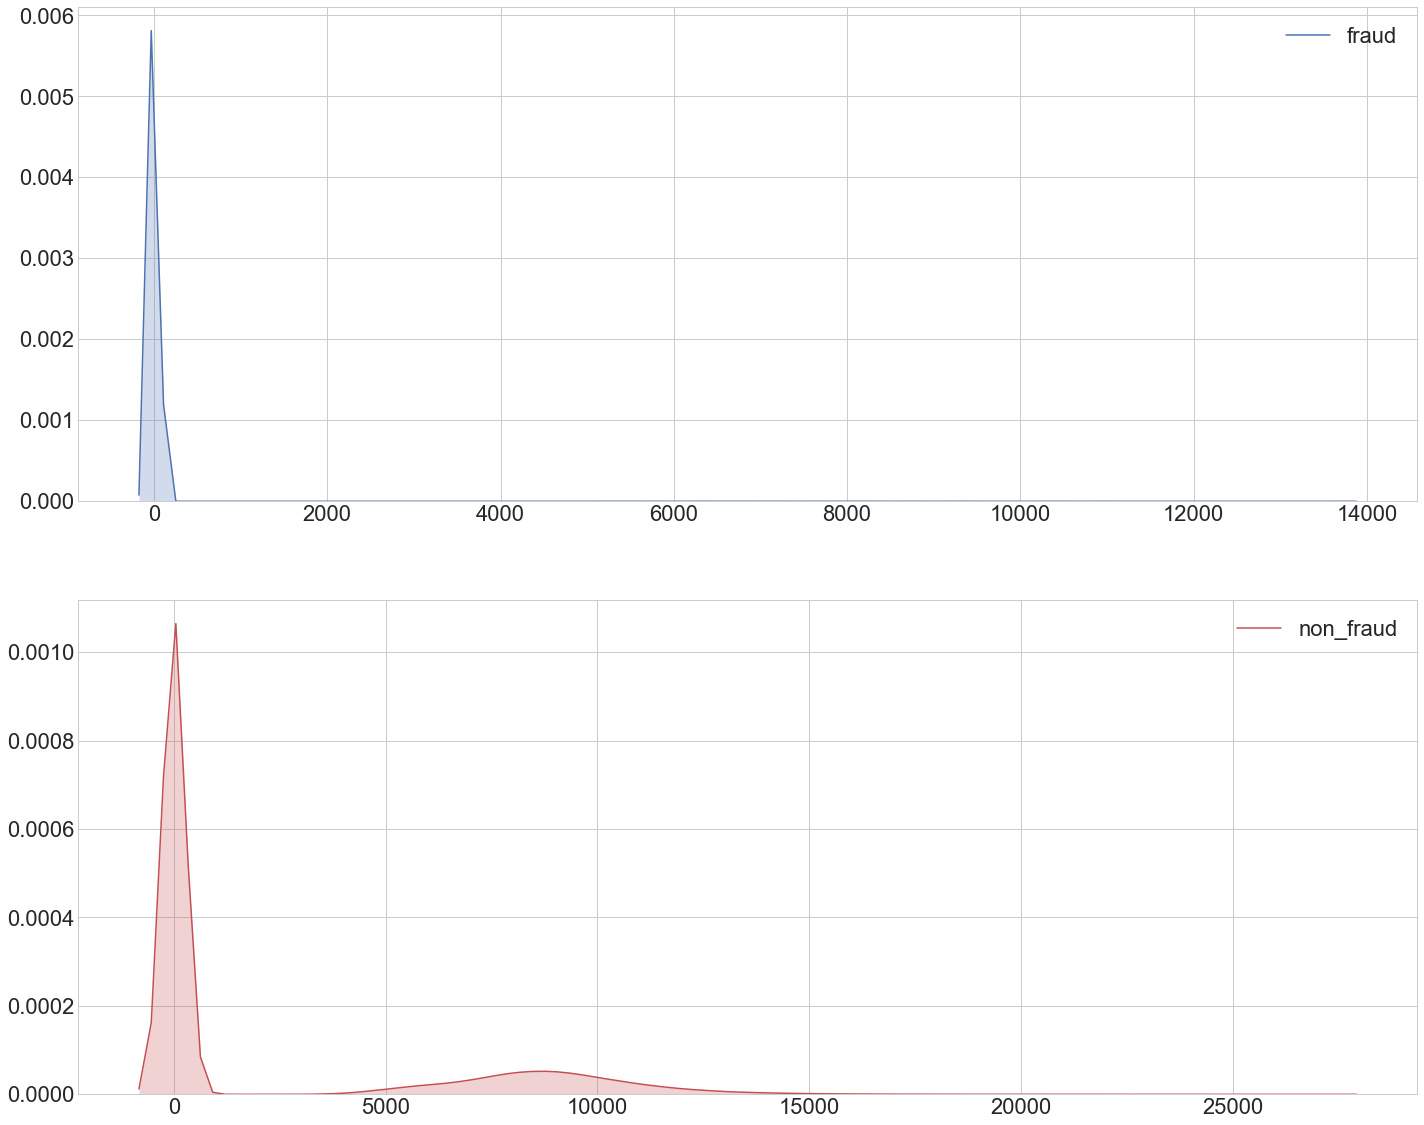

time: 3.65 s


In [152]:
non_fraud_df = msgLog[msgLog['fraud']==0]
# plot of 2 variables
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))
#ax1.title('Maximum Payment distributions for fraudulent and non fraudulent customers')
p1=sns.kdeplot(non_fraud_df['paid_max'], shade=True, color="r", label = 'non_fraud', ax = ax2)
p1=sns.kdeplot(fraud_df['paid_max'], shade=True, color="b", label = 'fraud', ax= ax1)
#sns.plt.show()

Text(0, 0.5, 'maximum payment')

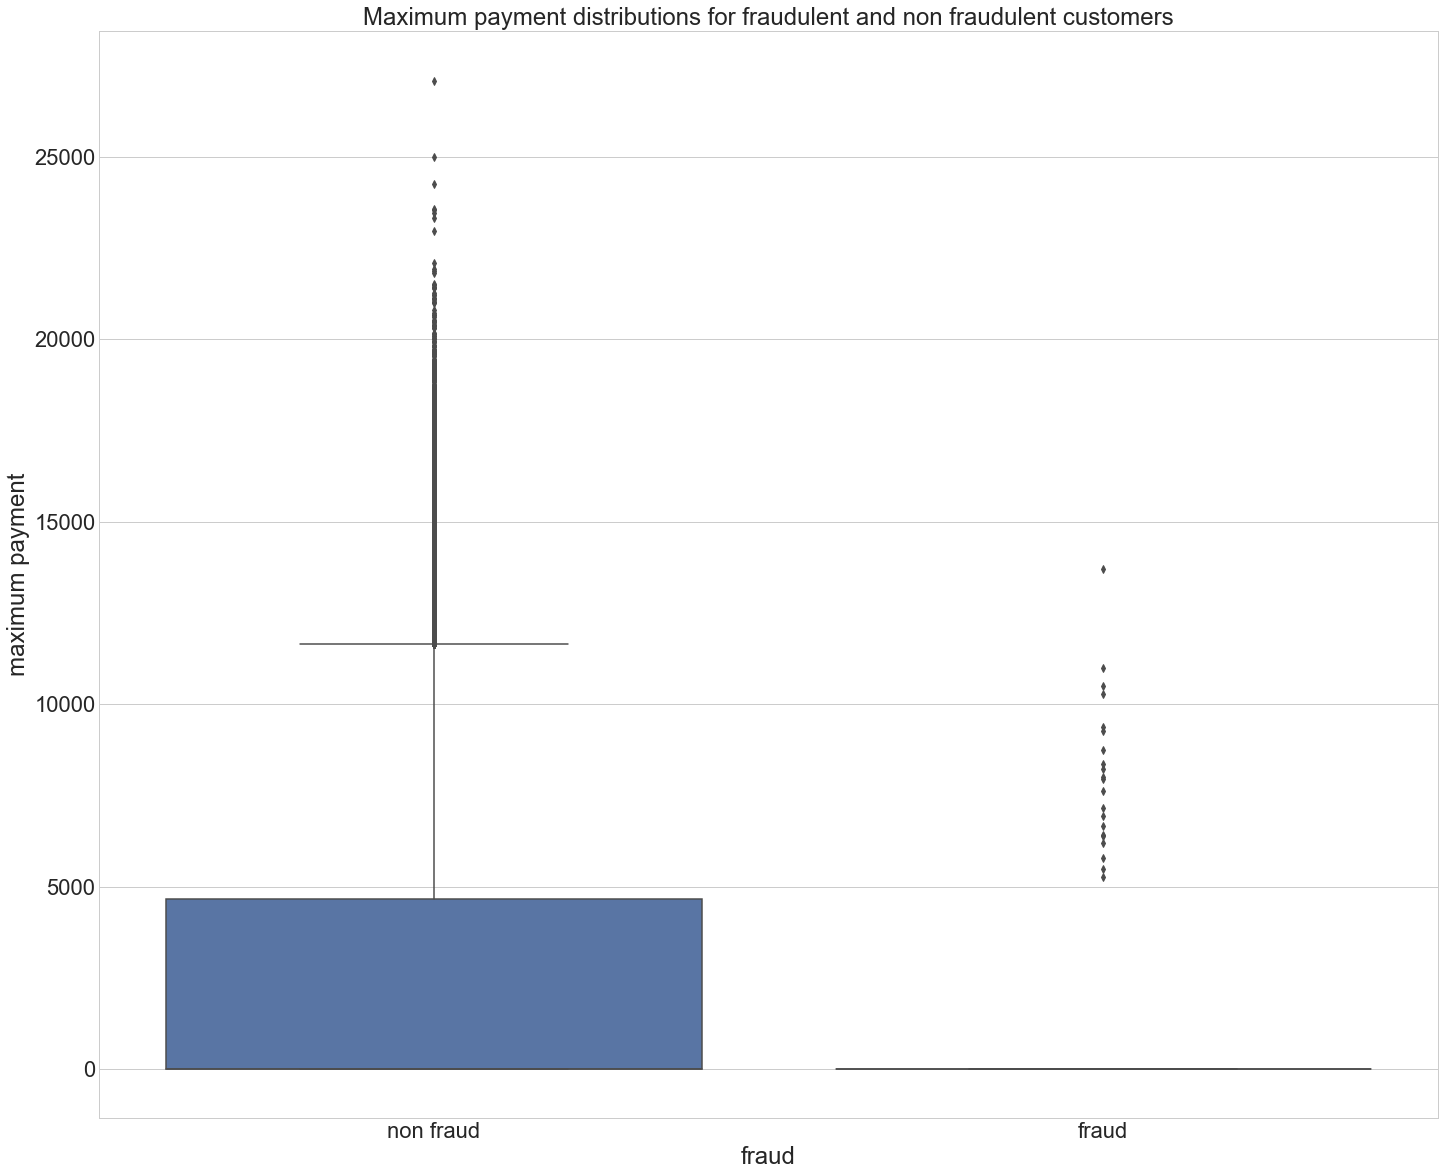

time: 361 ms


In [153]:
f, (ax1) = plt.subplots(1, 1, figsize=(24,20))
sns.boxplot( x=msgLog["fraud"], y=msgLog["paid_max"] , ax = ax1)
ax1.set_title('Maximum payment distributions for fraudulent and non fraudulent customers')
plt.xticks(np.arange(2), ['non fraud', 'fraud' ])
plt.ylabel('maximum payment')
# mean payment

Text(0, 0.5, 'mean payment')

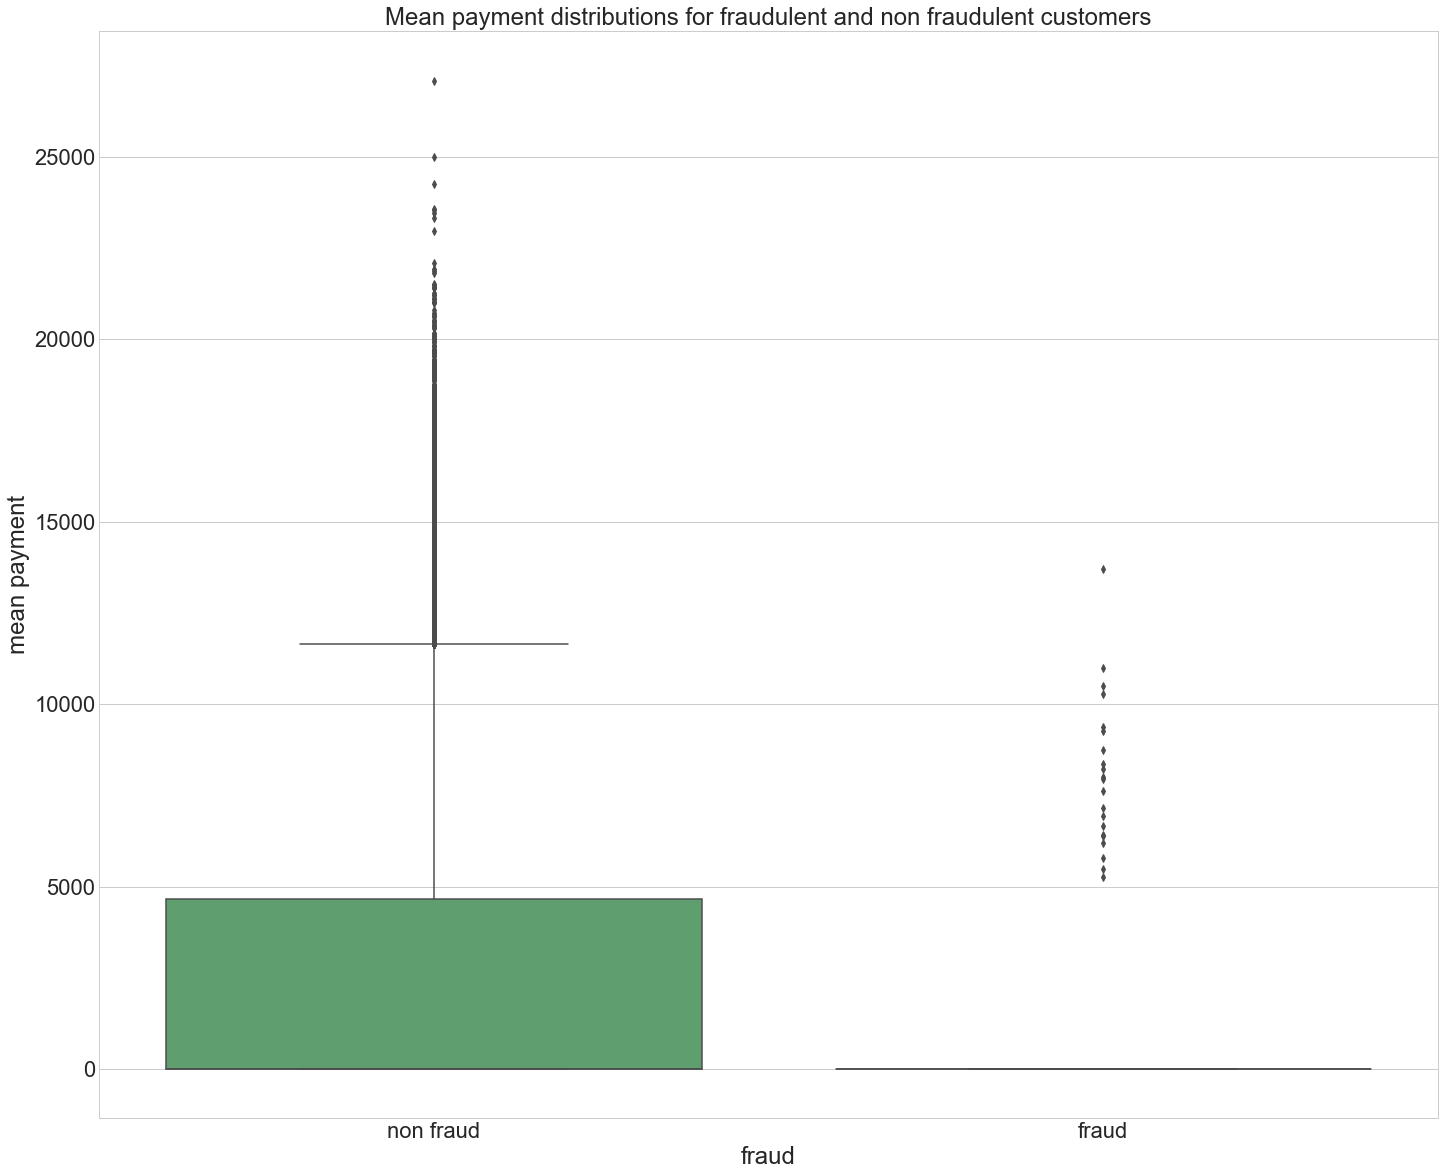

time: 350 ms


In [154]:
f, (ax1) = plt.subplots(1, 1, figsize=(24,20))
sns.boxplot( x=msgLog["fraud"], y=msgLog["paid_mean"] , ax = ax1, color = 'g')
ax1.set_title('Mean payment distributions for fraudulent and non fraudulent customers')
plt.xticks(np.arange(2), ['non fraud', 'fraud' ])
plt.ylabel('mean payment')

Text(0, 0.5, 'min payment')

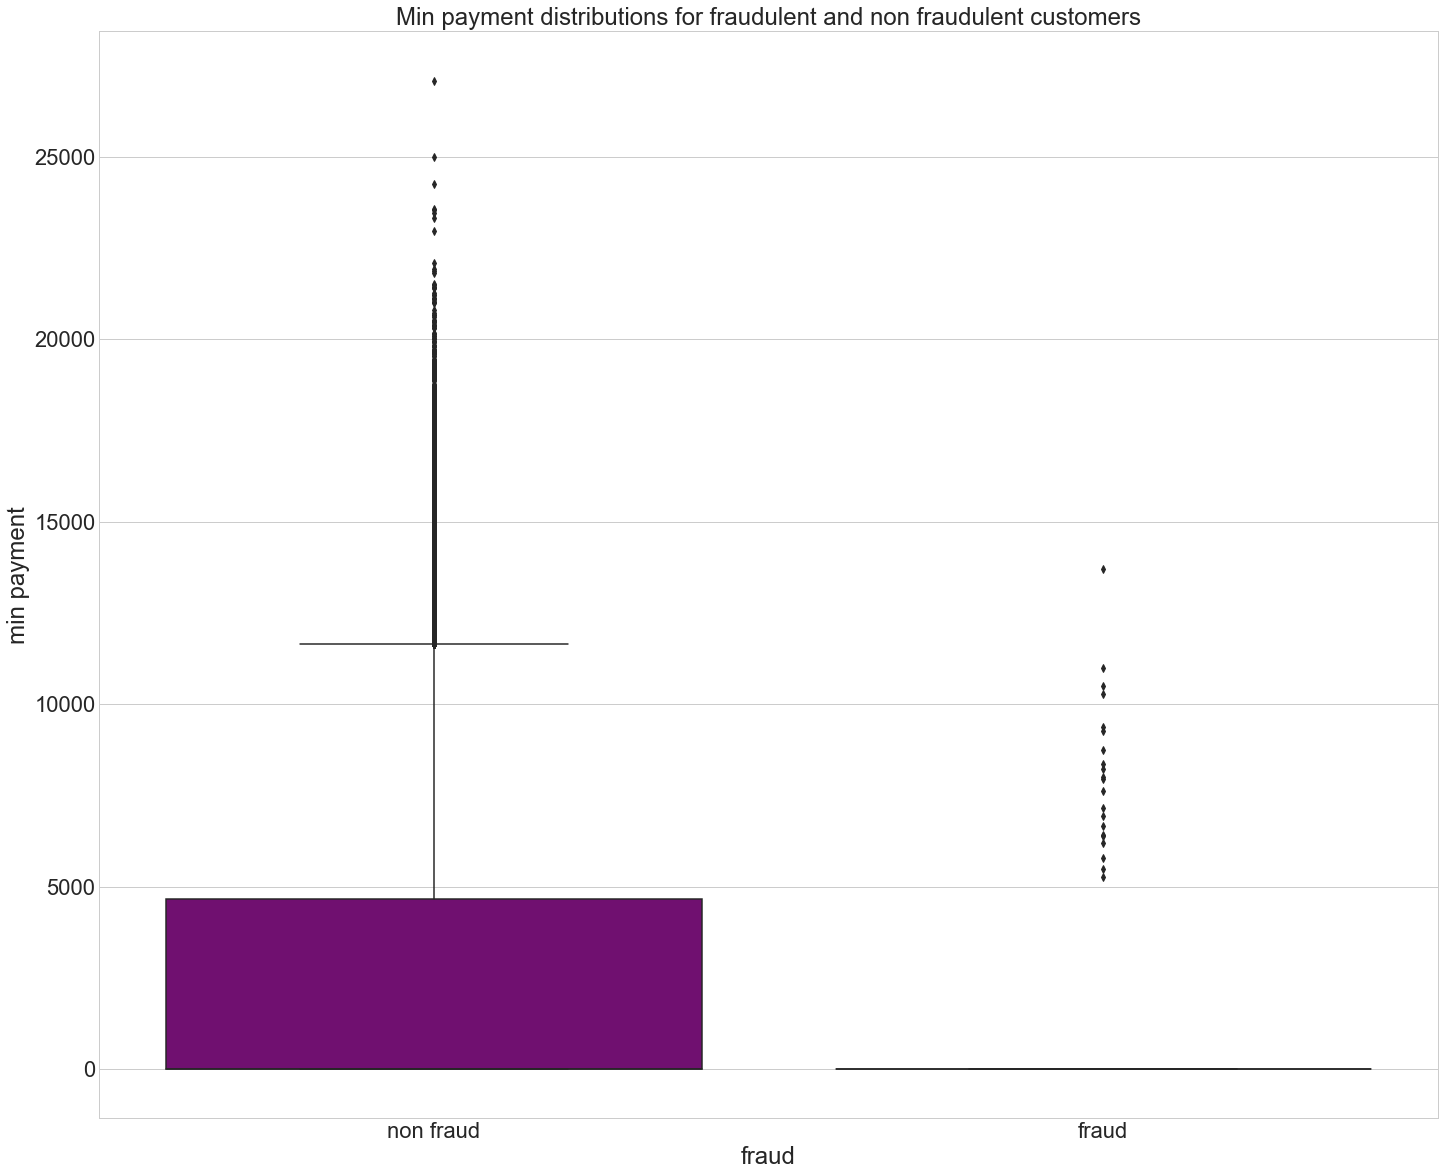

time: 350 ms


In [155]:
f, (ax1) = plt.subplots(1, 1, figsize=(24,20))
sns.boxplot( x=msgLog["fraud"], y=msgLog["paid_min"] , ax = ax1, color = 'purple')
ax1.set_title('Min payment distributions for fraudulent and non fraudulent customers')
plt.xticks(np.arange(2), ['non fraud', 'fraud' ])
plt.ylabel('min payment')
# plot that shows gender discrepancies between people

In [156]:
msgLog.columns

Index(['new_id', 'fraud', 'device', 'no_actions', 'min_trans_diff',
       'max_trans_diff', 'quote_time_diff', 'claim_pay_diff',
       'mean_trans_time', 'total_trans_time', 'paid_min', 'paid_max',
       'paid_mean', 'paid_diff', 'occupant_count', 'holder_gender',
       'holder_age', 'holder_error_in_gender', 'occupant_error_in_gender',
       'min_occupant_age', 'max_occupant_age', 'mean_occupant_age',
       'mean_household_age', 'house_type', 'house_square_footage',
       'house_number_of_bedrooms', 'house_number_of_floors', 'street',
       'street_number', 'suburb', 'email_provider'],
      dtype='object')

time: 1.99 ms


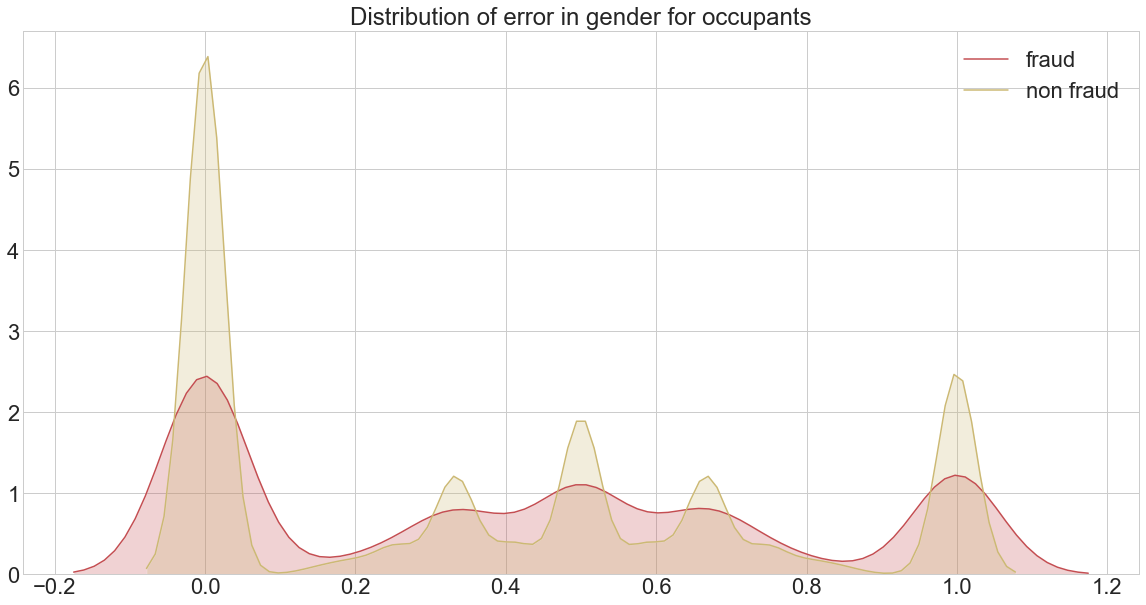

time: 2 s


In [157]:
"""f, axes = plt.subplots(2, 2, figsize=(20, 20))
axes[0, 0].set_title("Fraud \n (don't use for reference)", fontsize=14)
sns.distplot( fraud_df['holder_error_in_gender'] , color="skyblue", ax=axes[0, 0])
sns.distplot( fraud_df['occupant_error_in_gender'] , color="olive", ax=axes[0, 1])
sns.distplot( non_fraud_df['holder_error_in_gender'] , color="gold", ax=axes[1, 0])
sns.distplot( non_fraud_df['occupant_error_in_gender'] , color="teal", ax=axes[1, 1])"""

plt.figure(figsize=(20,10))
plt.title('Distribution of error in gender for occupants')
p1=sns.kdeplot(fraud_df['occupant_error_in_gender'], shade=True, color="r", label = 'fraud')
p1=sns.kdeplot(non_fraud_df['occupant_error_in_gender'], shade=True, color="y", label = 'non fraud')
# mins_trans_diff predictor

Text(0.5, 0, 'maximum transaction difference')

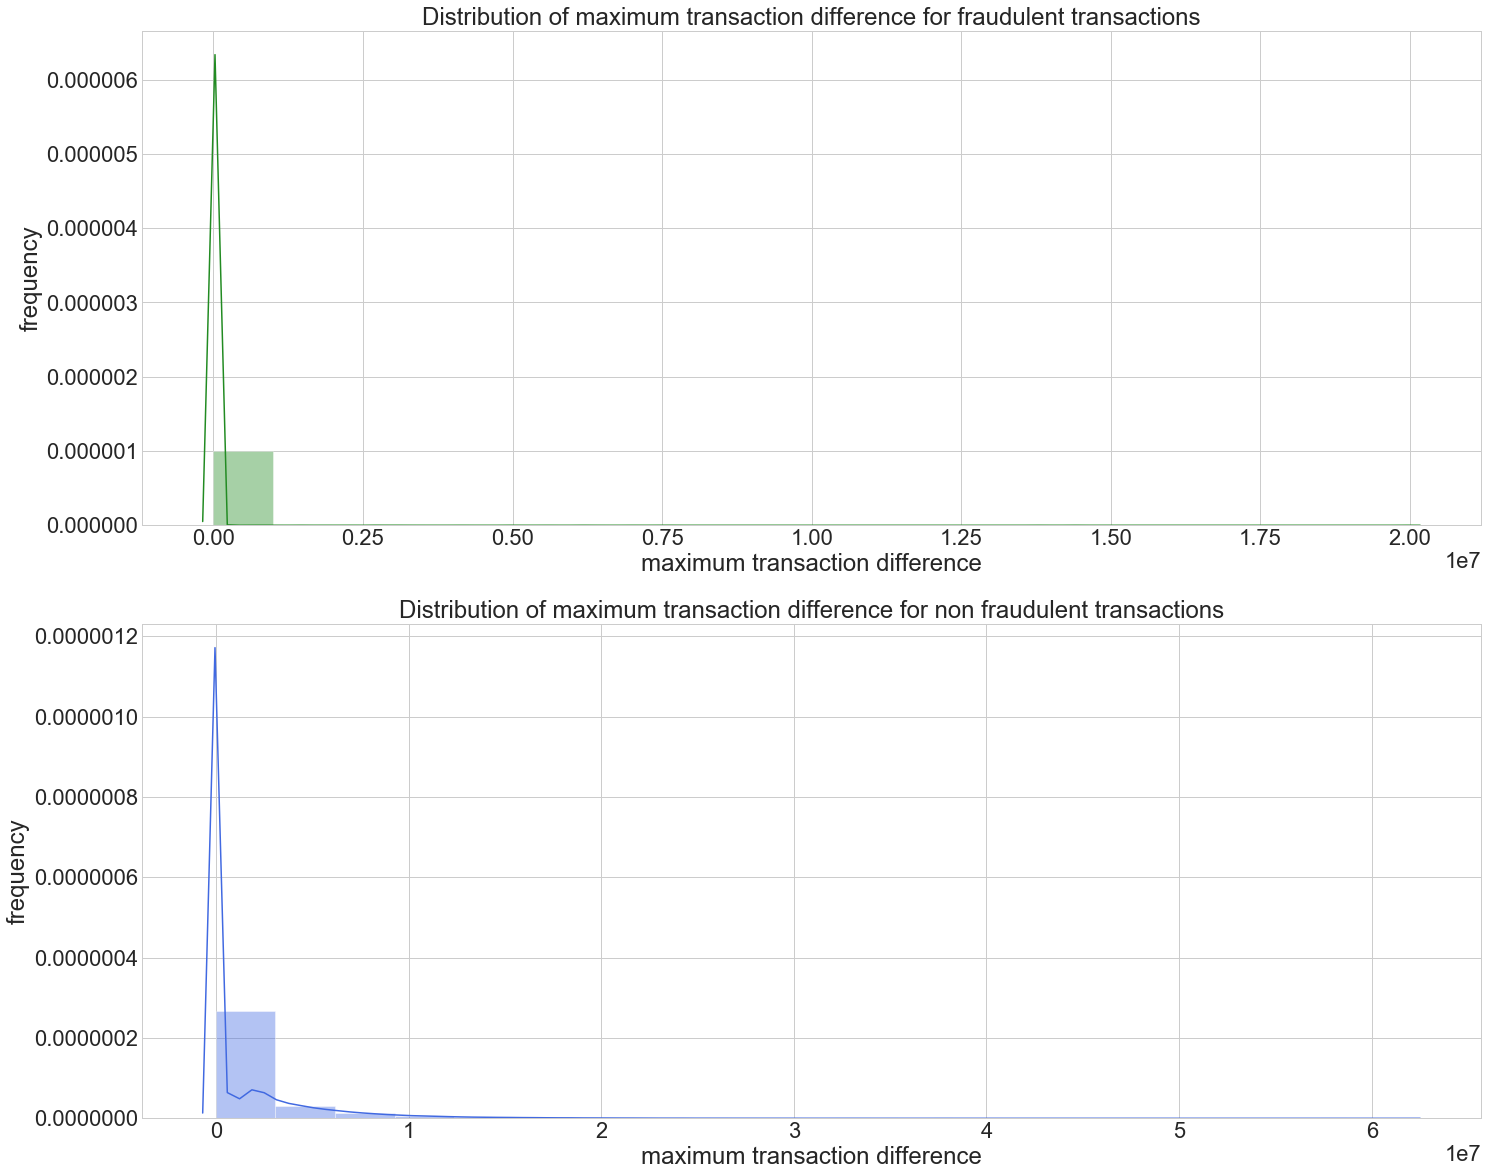

time: 4.38 s


In [158]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))
sns.distplot(fraud_df["max_trans_diff"] , ax = ax1, color = 'forestgreen', bins=20)
ax1.set_title('Distribution of maximum transaction difference for fraudulent transactions')
ax1.set_ylabel('frequency')
ax1.set_xlabel('maximum transaction difference')
sns.distplot(non_fraud_df["max_trans_diff"] , ax = ax2, color = 'royalblue', bins=20)
ax2.set_title('Distribution of maximum transaction difference for non fraudulent transactions')
ax2.set_ylabel('frequency')
ax2.set_xlabel('maximum transaction difference')


Text(0, 0.5, 'maximum transaction difference')

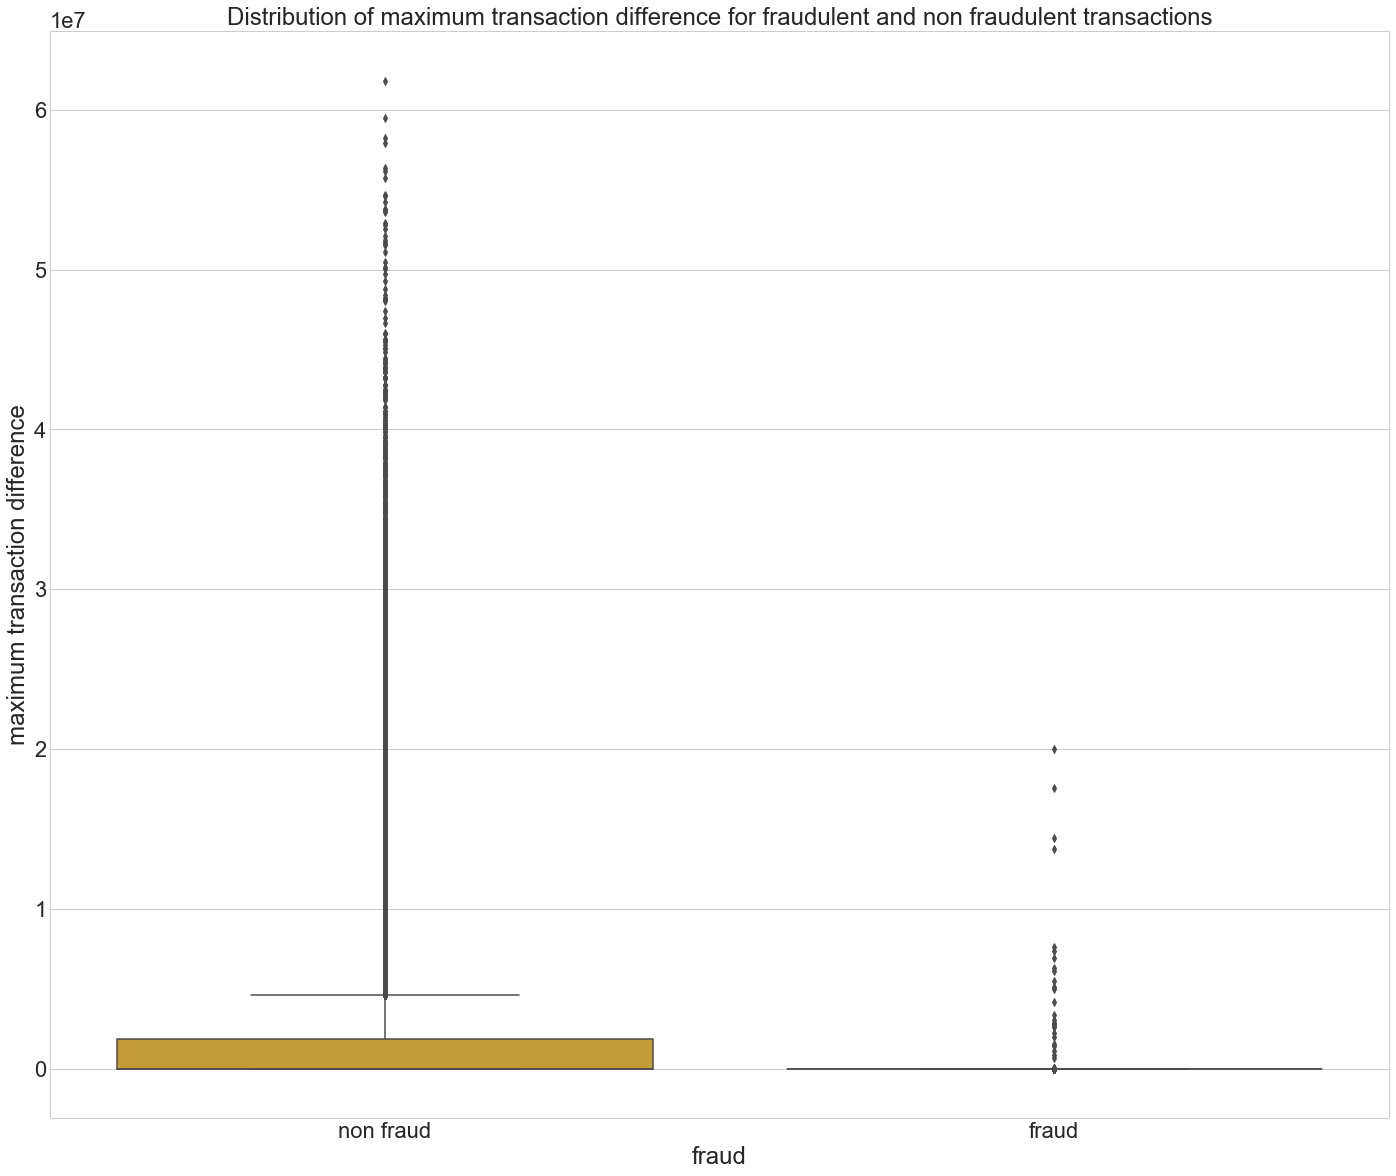

time: 558 ms


In [159]:
f, (ax1) = plt.subplots(1, 1, figsize=(24,20))
sns.boxplot( x=msgLog["fraud"], y=msgLog["max_trans_diff"] , ax = ax1, color = 'goldenrod')
#sns.violinplot( x=msgLog["fraud"], y=msgLog["max_trans_diff"] , ax = ax1)
ax1.set_title('Distribution of maximum transaction difference for fraudulent and non fraudulent transactions')
plt.xticks(np.arange(2), ['non fraud', 'fraud' ])
plt.ylabel('maximum transaction difference')

Text(0, 0.5, 'minimum transaction difference')

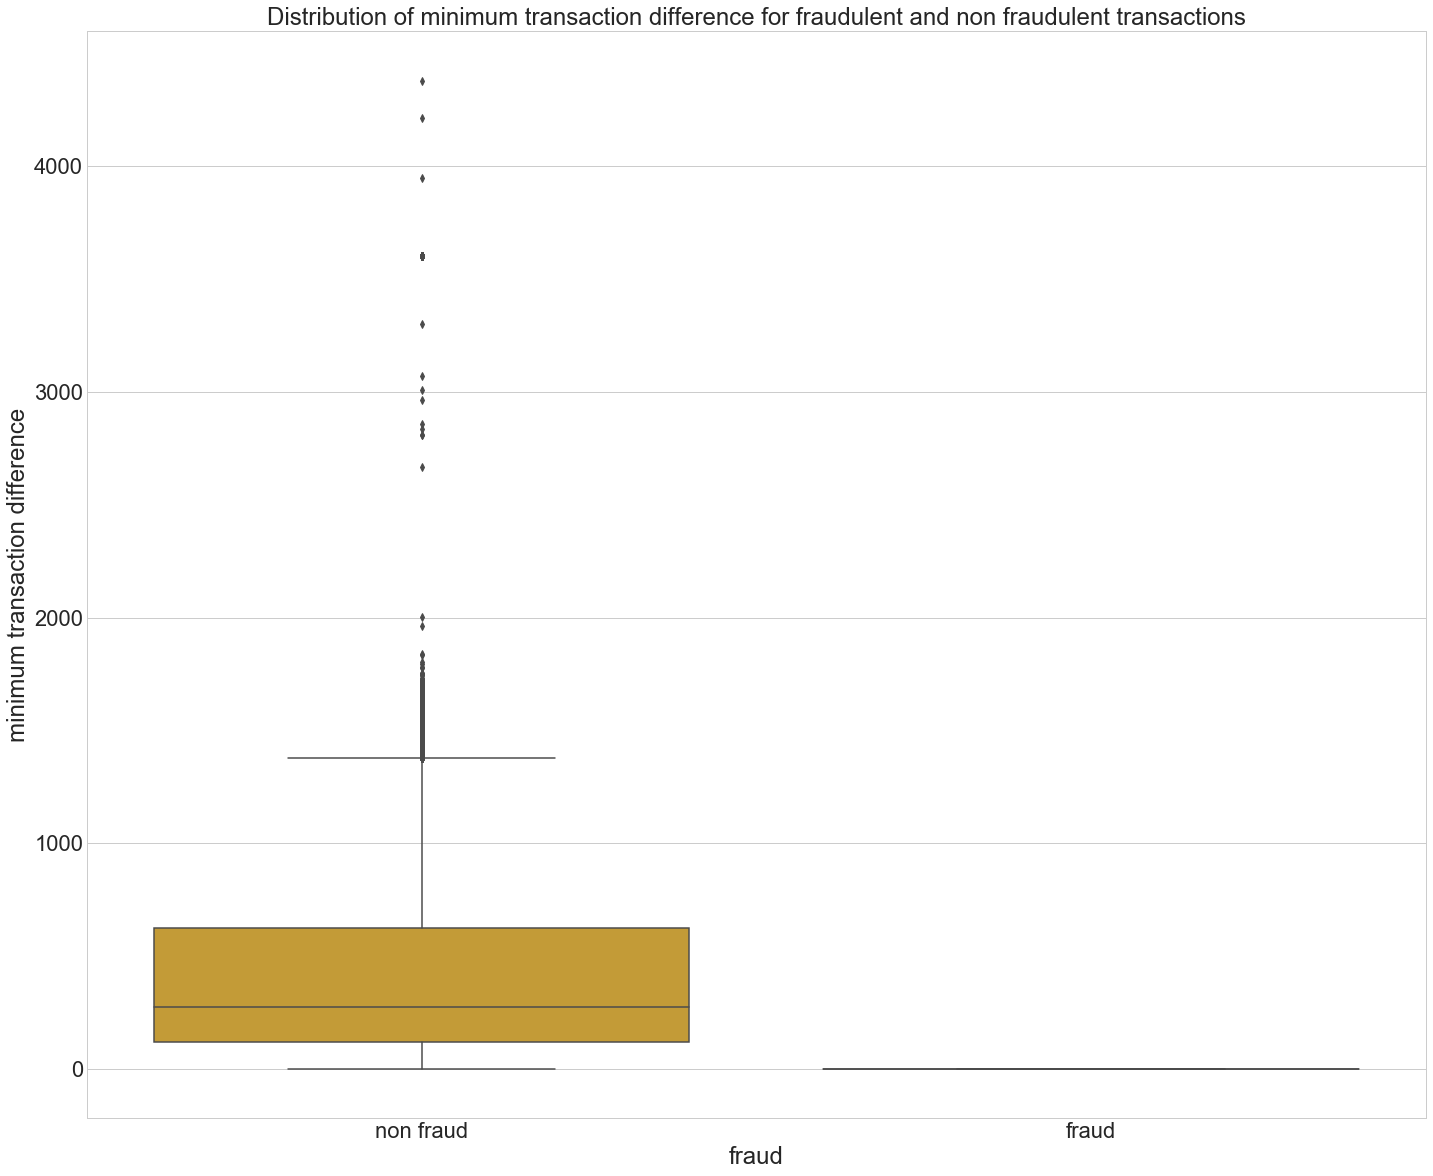

time: 328 ms


In [160]:
f, (ax1) = plt.subplots(1, 1, figsize=(24,20))
sns.boxplot( x=msgLog["fraud"], y=msgLog["min_trans_diff"] , ax = ax1, color = 'goldenrod')
#sns.violinplot( x=msgLog["fraud"], y=msgLog["max_trans_diff"] , ax = ax1)
ax1.set_title('Distribution of minimum transaction difference for fraudulent and non fraudulent transactions')
plt.xticks(np.arange(2), ['non fraud', 'fraud' ])
plt.ylabel('minimum transaction difference')

Text(0.5, 1.0, 'Distribution of maximum transaction difference for fraudulent transactions')

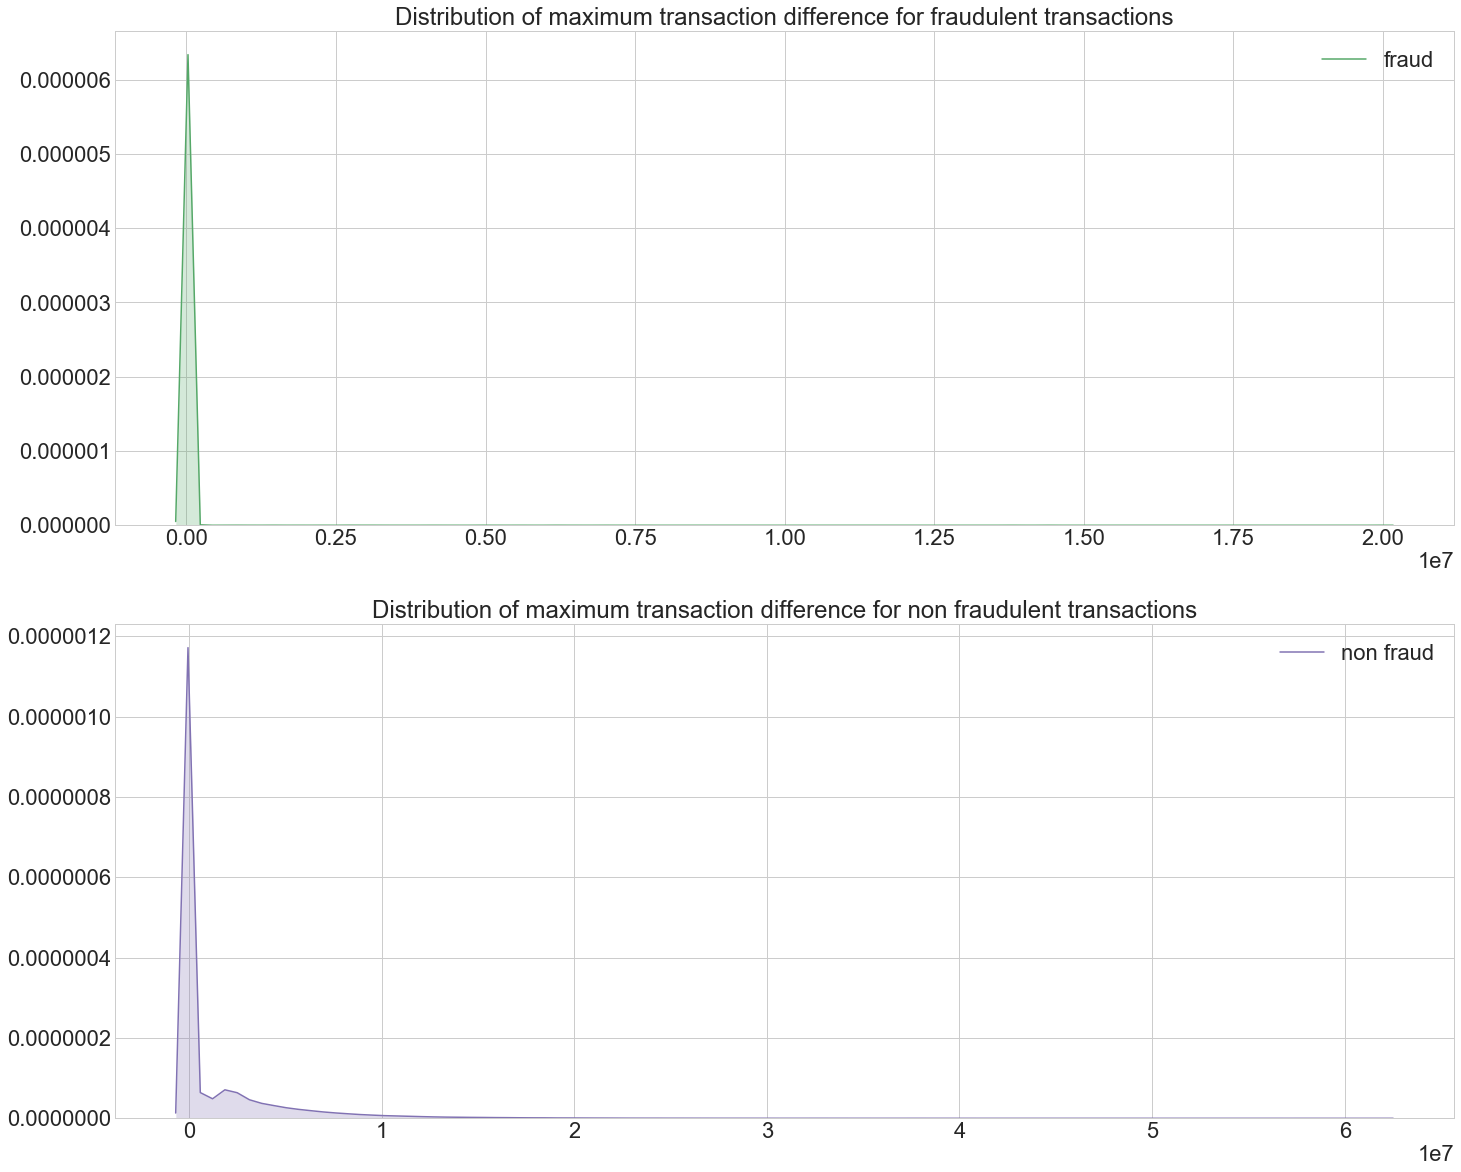

time: 4.39 s


In [161]:
# plot of 2 variables
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))
p1=sns.kdeplot(non_fraud_df['max_trans_diff'], shade=True, color="m", label = 'non fraud', ax = ax2)
p1=sns.kdeplot(fraud_df['max_trans_diff'], shade=True, color="g", label = 'fraud', ax = ax1)
ax2.set_title('Distribution of maximum transaction difference for non fraudulent transactions')
ax1.set_title('Distribution of maximum transaction difference for fraudulent transactions')
#sns.plt.show()

Text(0.5, 1.0, 'Distribution of mean transaction time for fraudulent transactions')

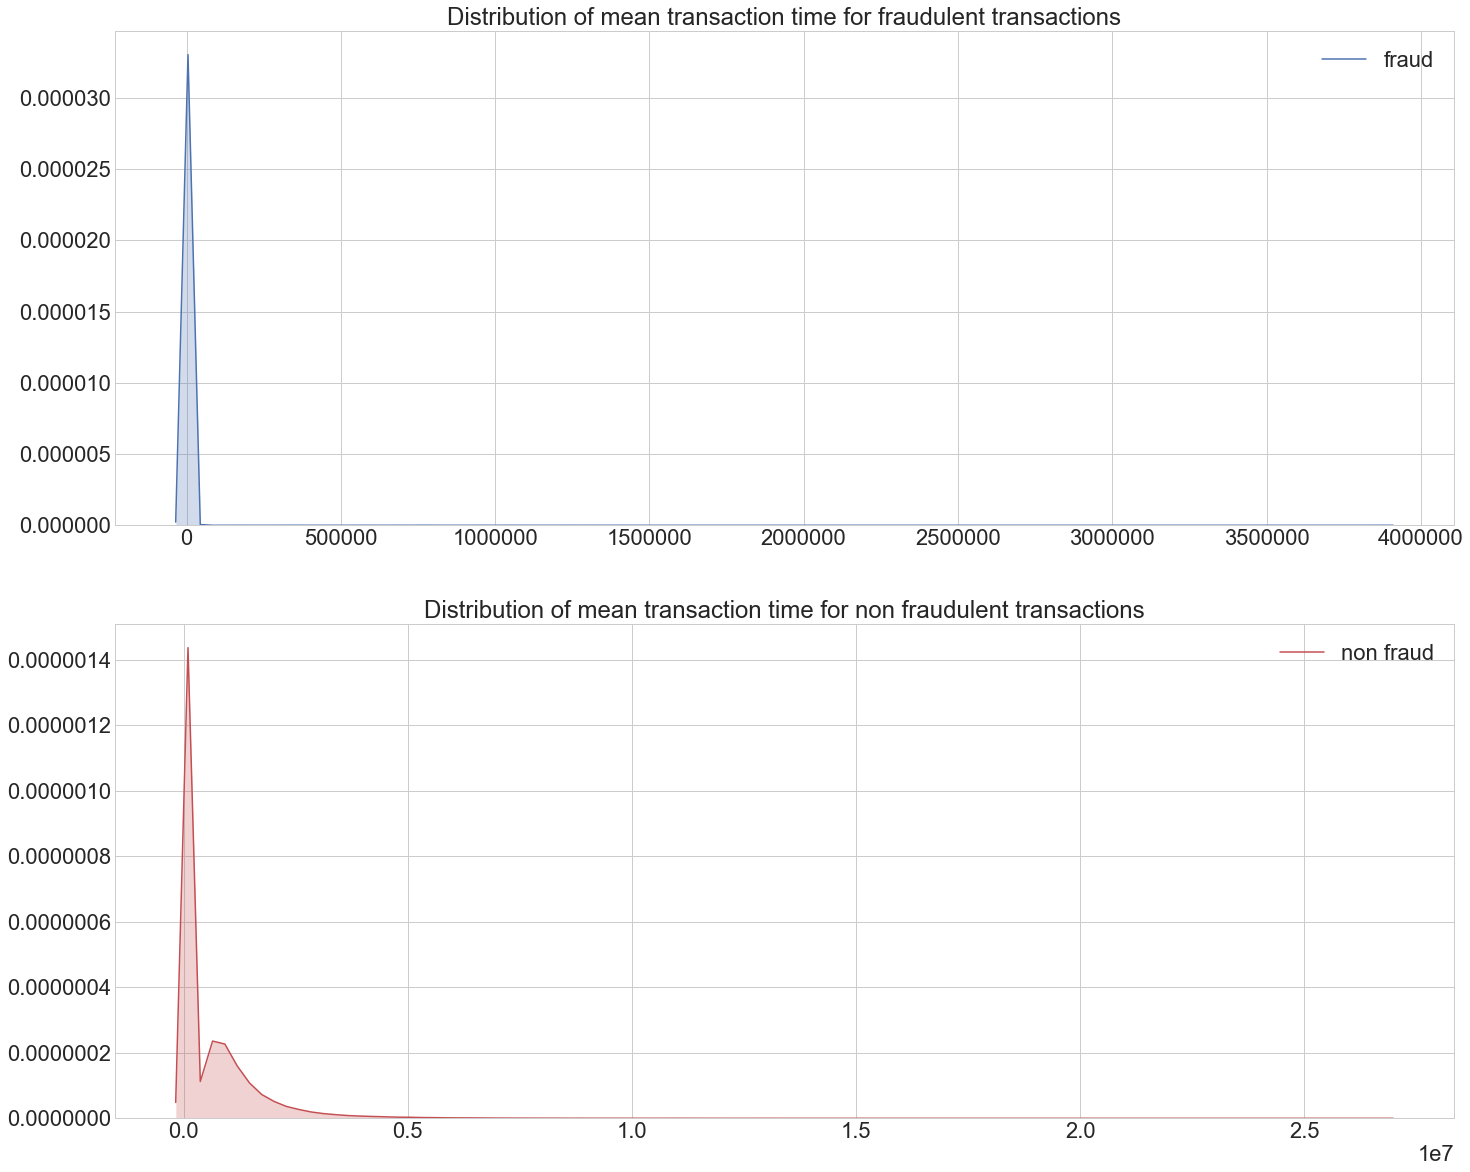

time: 4.63 s


In [162]:
# plot of 2 variables
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))
p1=sns.kdeplot(non_fraud_df['mean_trans_time'], shade=True, color="r", label = 'non fraud', ax = ax2)
p1=sns.kdeplot(fraud_df['mean_trans_time'], shade=True, color="b", label = 'fraud', ax = ax1)
ax2.set_title('Distribution of mean transaction time for non fraudulent transactions')
ax1.set_title('Distribution of mean transaction time for fraudulent transactions')
#sns.plt.show()

Text(0.5, 1.0, 'Distribution of total transaction time for fraudulent transactions')

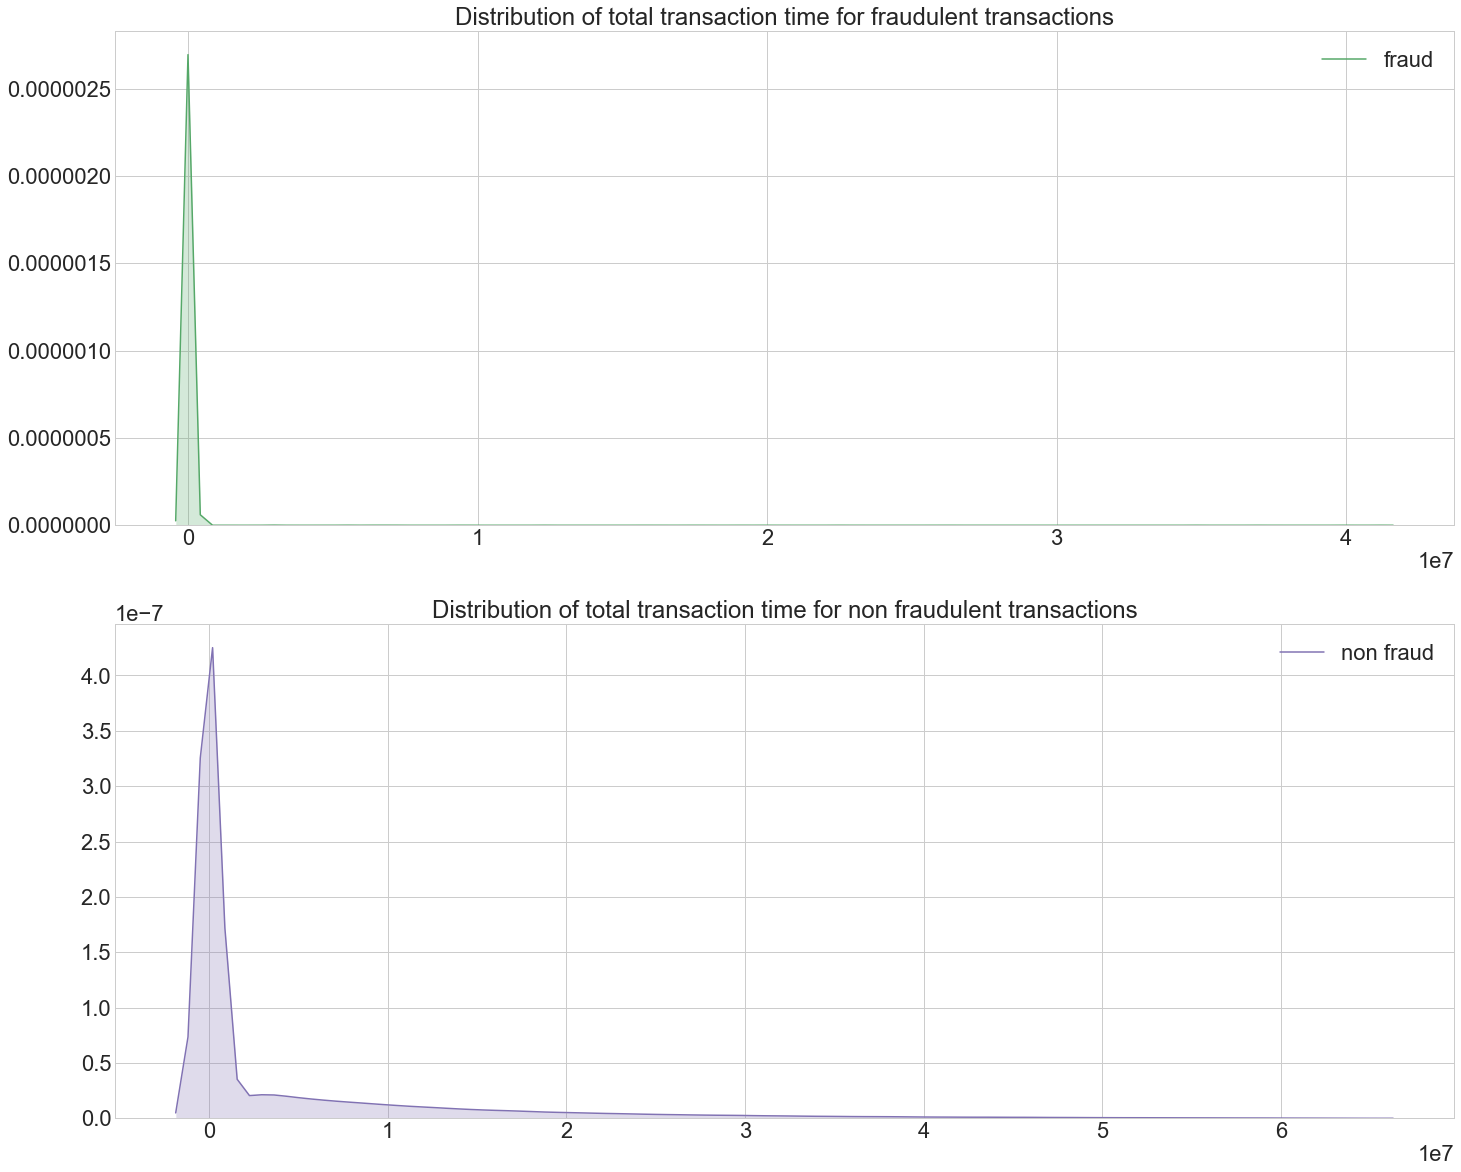

time: 3.73 s


In [163]:
# plot of 2 variables
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))
p1=sns.kdeplot(non_fraud_df['total_trans_time'], shade=True, color="m", label = 'non fraud', ax = ax2)
p1=sns.kdeplot(fraud_df['total_trans_time'], shade=True, color="g", label = 'fraud', ax = ax1)
ax2.set_title('Distribution of total transaction time for non fraudulent transactions')
ax1.set_title('Distribution of total transaction time for fraudulent transactions')
#sns.plt.show()

Text(0, 0.5, 'mean transaction time')

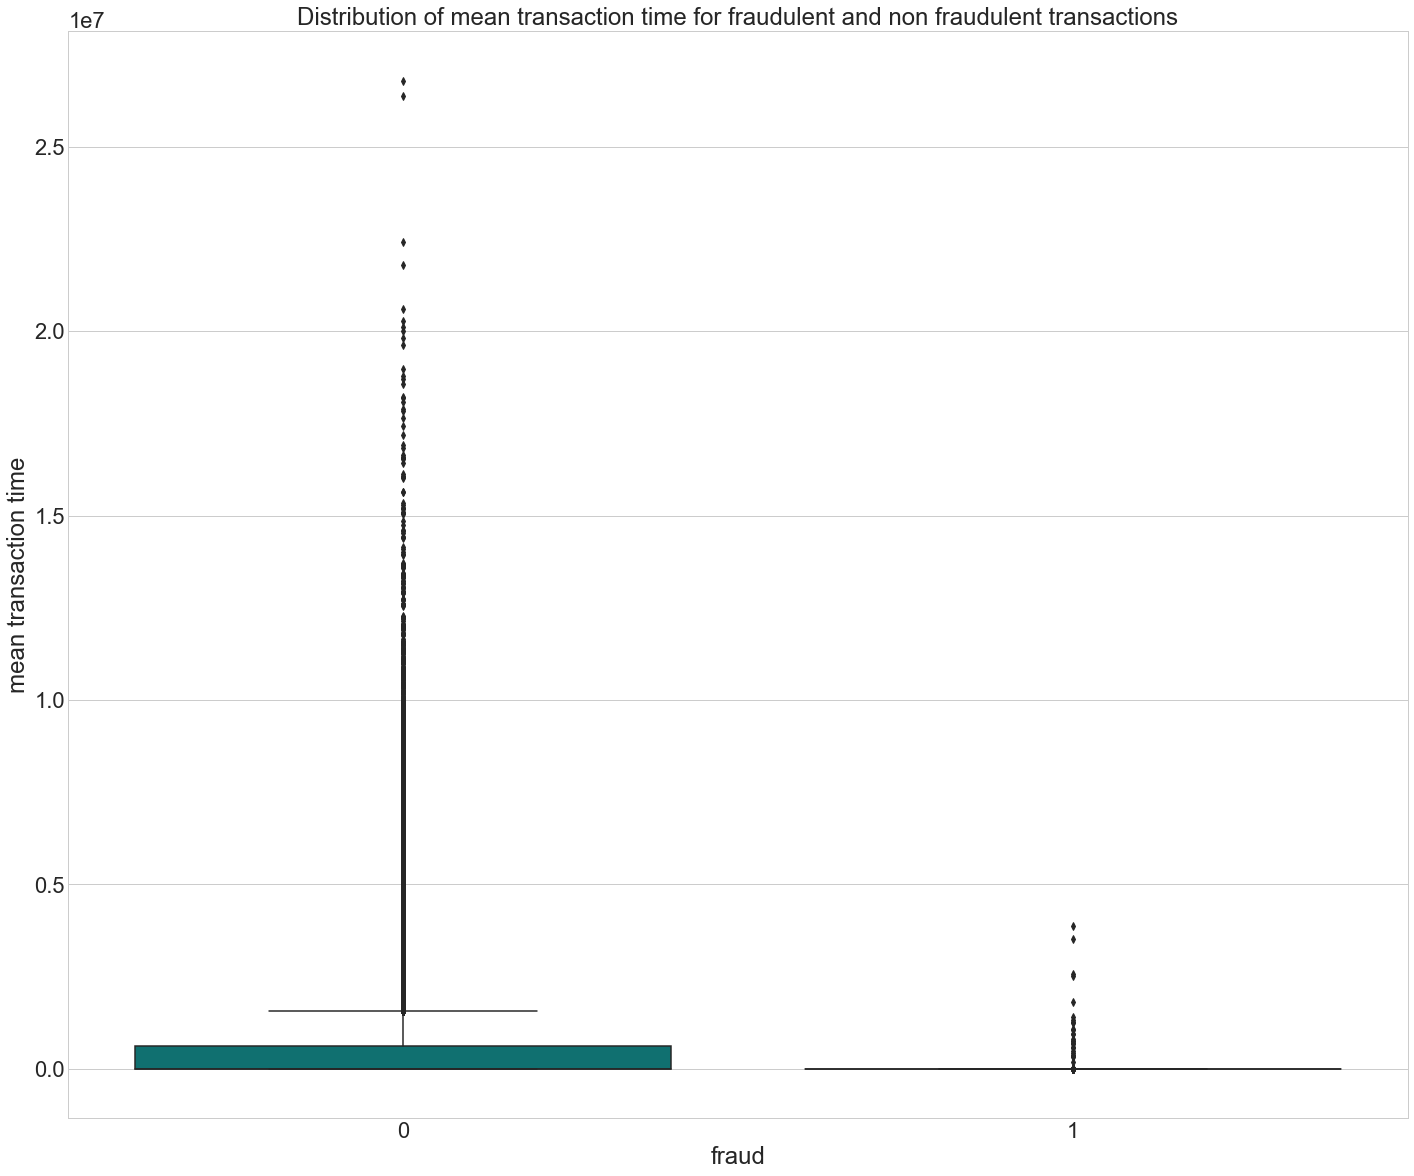

time: 476 ms


In [164]:
f, (ax1) = plt.subplots(1, 1, figsize=(24,20))
sns.boxplot( x=msgLog["fraud"], y=msgLog["mean_trans_time"] , ax = ax1, color = 'teal')
#sns.violinplot( x=msgLog["fraud"], y=msgLog["max_trans_diff"] , ax = ax1)
ax1.set_title('Distribution of mean transaction time for fraudulent and non fraudulent transactions')
plt.ylabel('mean transaction time')

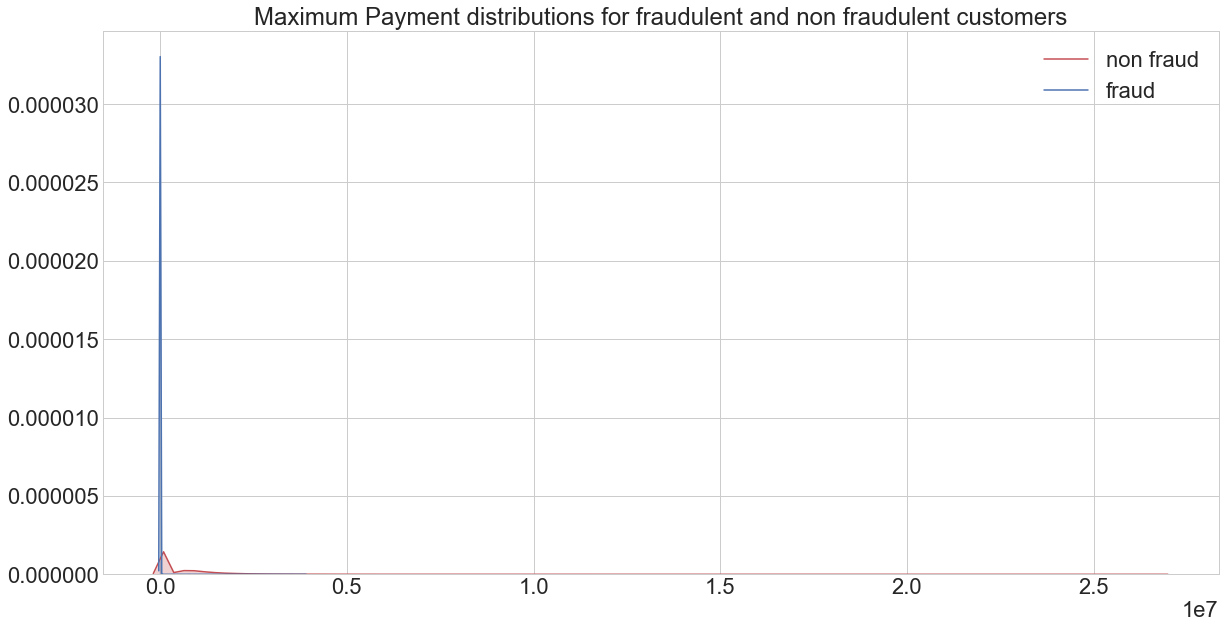

time: 4.35 s


In [165]:
# plot of 2 variables
plt.figure(figsize=(20,10))
plt.title('Maximum Payment distributions for fraudulent and non fraudulent customers')
p1=sns.kdeplot(non_fraud_df['mean_trans_time'], shade=True, color="r", label = 'non fraud')
p1=sns.kdeplot(fraud_df['mean_trans_time'], shade=True, color="b", label = 'fraud')
#sns.plt.show()
# # Correlation Matrix
# To find which features are helpful in predicting fraud


"sub_sample_corr = sample.corr()\nsns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)\nax1.set_title('Subsample Correlation Matrix \n (use for reference)', fontsize=20)\nplt.show()"

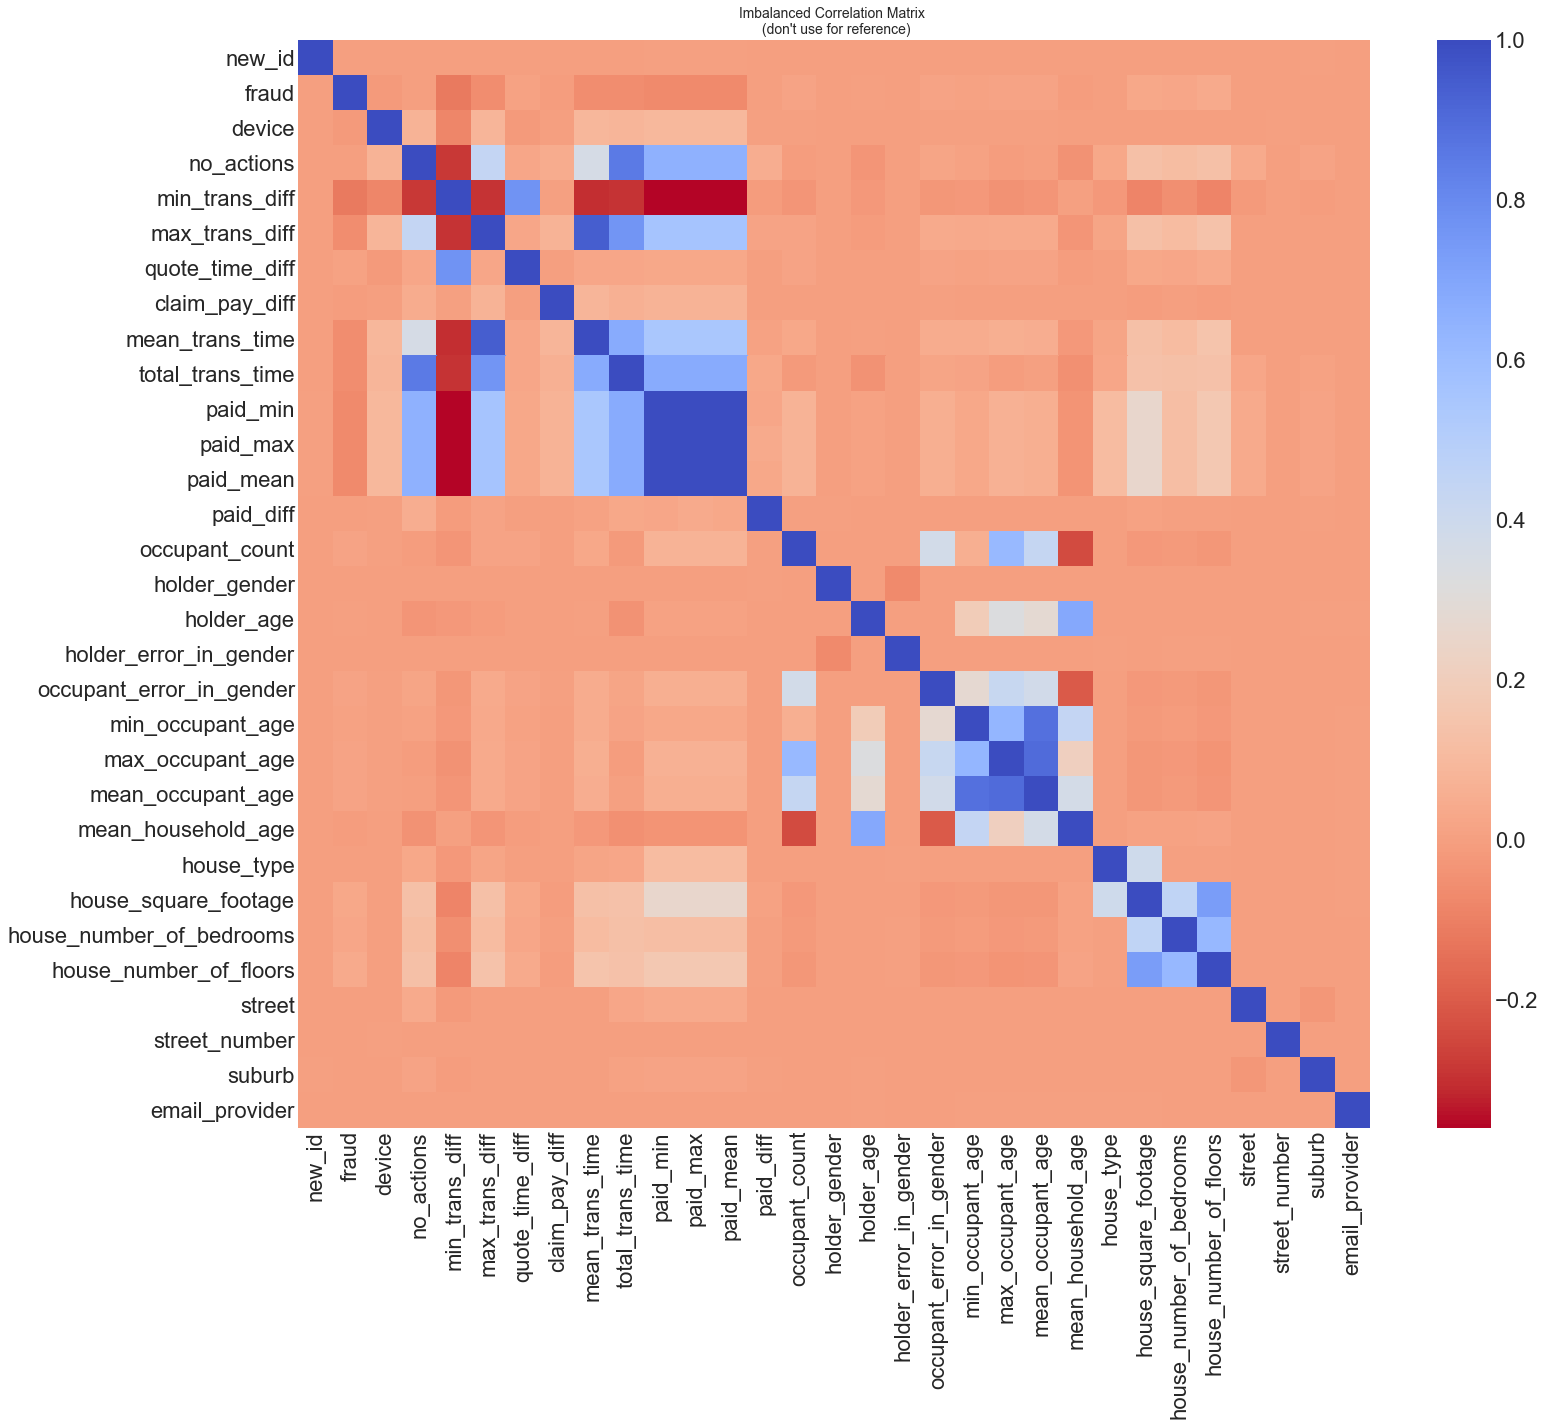

time: 1.86 s


In [168]:
f, (ax1) = plt.subplots(1, 1, figsize=(24,20))
#change font size
plt.rcParams.update({'font.size': 20})
# Entire DataFrame
corr = msgLog.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)
"""sub_sample_corr = sample.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax1.set_title('Subsample Correlation Matrix \n (use for reference)', fontsize=20)
plt.show()"""
# There seems to be a correlation between using a mobile_app or mobiel browser and committing insurance fraud. There also seems to be a strong negative correlation between min_difference and insurance fraud.
# Comparing fradulent customers with genuine customers in order to find which variables are useful. Will use heatmap to conduct analysis.

In [171]:
saved = msgLog.head(100000)
saved = saved.append(fraud_df.head(20000), ignore_index = True)
print(len(saved[saved['fraud']==1]))
saved.drop_duplicates(keep = 'first', inplace = True)
print(len(saved[saved['fraud']==1]))



12130
10494
time: 235 ms


# Splitting the Data
## Split into train and test sets

In [173]:

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(msgLog['fraud'].value_counts()[0]/len(msgLog) * 100,2), '% of the dataset')
print('Frauds', round(msgLog['fraud'].value_counts()[1]/len(msgLog) * 100,2), '% of the dataset')

X = saved.drop('fraud', axis=1)
y = saved['fraud']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

    # Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values
# Clearly, there is a huge difference in correlation of variables between fraudulent and genuine entries. This should be useful in providing a trend from which we can build ML models

No Frauds 98.34 % of the dataset
Frauds 1.66 % of the dataset
Train: [ 20018  20019  20020 ... 108855 108856 108857] Test: [     0      1      2 ... 100460 100461 100462]
Train: [     0      1      2 ... 108855 108856 108857] Test: [ 20018  20019  20020 ... 102559 102560 102561]
Train: [     0      1      2 ... 108855 108856 108857] Test: [ 40009  40010  40011 ... 104658 104659 104660]
Train: [     0      1      2 ... 108855 108856 108857] Test: [ 59995  59996  59997 ... 106756 106757 106758]
Train: [     0      1      2 ... 106756 106757 106758] Test: [ 80022  80023  80025 ... 108855 108856 108857]
time: 129 ms


# Model 1: XGBoost
## create model using XGBoost

In [174]:
trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.2, random_state = 5)
# Long computation in this cell (~1.8 minutes)
weights = (y == 0).sum() / (1.0 * (y == 1).sum())
clf = xgb.XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, probabilities[:, 1])))



AUPRC = 1.0
time: 2.89 s


In [175]:
trainX.head()



,new_id,device,no_actions,min_trans_diff,max_trans_diff,quote_time_diff,claim_pay_diff,mean_trans_time,total_trans_time,paid_min,paid_max,paid_mean,paid_diff,occupant_count,holder_gender,holder_age,holder_error_in_gender,occupant_error_in_gender,min_occupant_age,max_occupant_age,mean_occupant_age,mean_household_age,house_type,house_square_footage,house_number_of_bedrooms,house_number_of_floors,street,street_number,suburb,email_provider
19848,19848,2,2,553.53,553.53,553.53,0.00,553.53,553.53,0.00,0.00,0.00,0.00,6.00,0,26.00,1,0.40,27,32,28.20,27.83,1.00,393.43,4.00,1.00,54,78.00,432,21565
71823,71823,2,2,287.92,287.92,287.92,0.00,287.92,287.92,0.00,0.00,0.00,0.00,1.00,1,34.00,1,0.00,0,0,0.00,34.00,1.00,330.95,2.00,1.00,54,140.00,360,55674
34547,34547,2,2,159.54,159.54,159.54,0.00,159.54,159.54,0.00,0.00,0.00,0.00,4.00,0,41.00,1,1.00,5,39,18.67,24.25,0.00,0.00,0.00,0.00,32,52.00,85,44103
27445,27445,2,10,155.04,11693422.32,927.15,1126717.72,2479048.24,22311434.20,5643.63,5643.63,5643.63,0.00,2.00,1,60.00,0,0.00,60,60,60.00,60.00,0.00,185.75,2.00,1.00,66,147.00,23,75400
20954,20954,2,2,724.47,724.47,724.47,0.00,724.47,724.47,0.00,0.00,0.00,0.00,4.00,1,31.00,0,0.67,3,16,9.67,15.00,1.00,400.12,1.00,1.00,47,86.00,10,26971


time: 14 ms


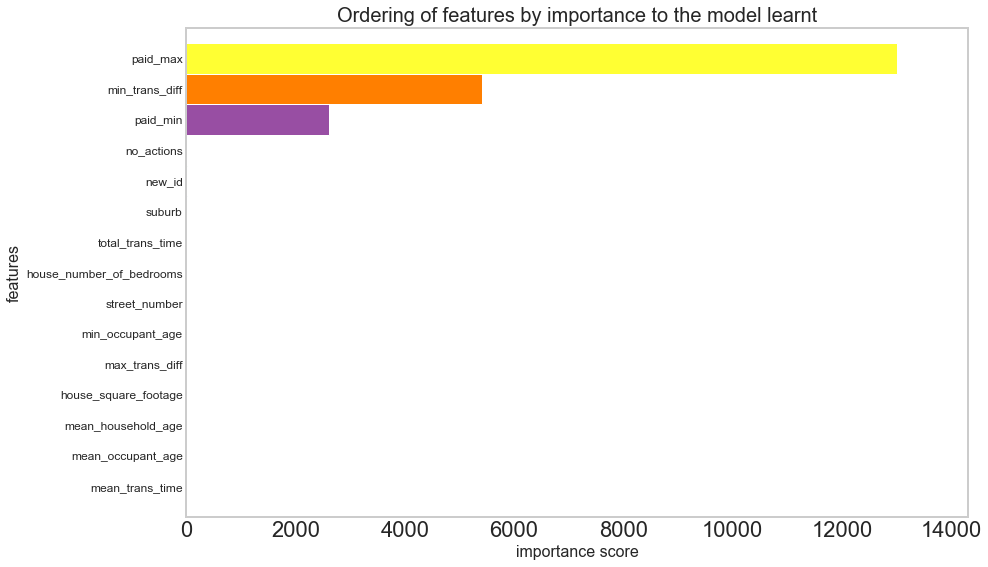

time: 233 ms


In [177]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = xgb.plot_importance(clf, height = 1, color = colours, grid = False, show_values = False, importance_type = 'cover', ax = ax);

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

    ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);


In [178]:
# Visualisation of ML model
xgb.to_graphviz(clf)

ImportError: You must install graphviz to plot tree

time: 21 ms


In [179]:
#Long computation in this cell (~6 minutes)
trainSizes, trainScores, crossValScores = learning_curve(xgb.XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4), trainX, trainY, scoring = 'average_precision')

time: 30.4 s


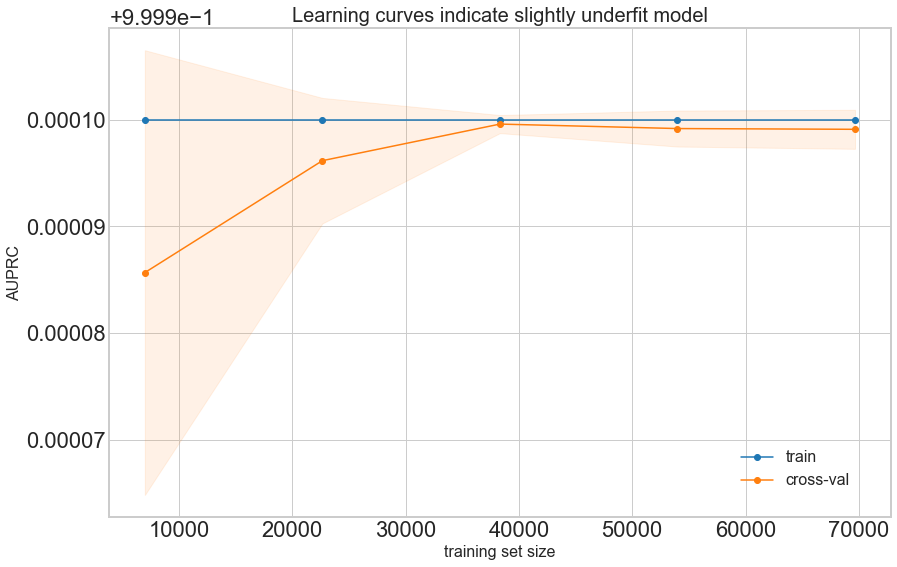

time: 211 ms


In [180]:
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd, crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()

plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16);
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);

Accuracy: 100.000000000%
f1_score: 100.000000000%
precision: 100.000000000%
recall: 100.000000000%
roc_auc_score:  1.0
AUPRC = 1.0
Average precision-recall score: 1.000000000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19689
           1       1.00      1.00      1.00      2083

    accuracy                           1.00     21772
   macro avg       1.00      1.00      1.00     21772
weighted avg       1.00      1.00      1.00     21772



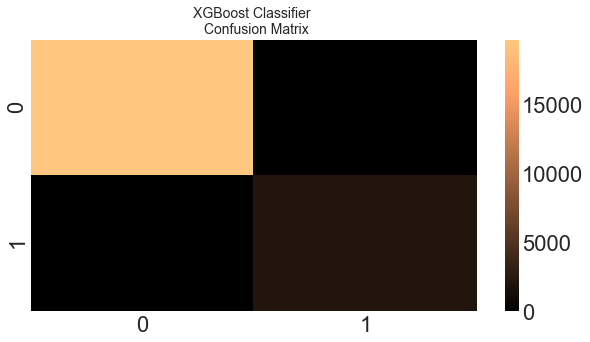

time: 212 ms


In [182]:
y_pred_xgb = clf.predict(testX)
predictions = [i for i in y_pred_xgb]

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy = accuracy_score(testY, predictions)
print("Accuracy: %.9f%%" % (accuracy * 100.0))
print("f1_score: %.9f%%" % (f1_score(testY, predictions) * 100.0))
print("precision: %.9f%%" % (precision_score(testY, predictions) * 100.0))
print("recall: %.9f%%" % (recall_score(testY, predictions) * 100.0))

#roc_auc_score
print('roc_auc_score: ', roc_auc_score(testY, predictions))

#AUPRC
print('AUPRC = {}'.format(average_precision_score(testY, probabilities[:, 1])))

#average precision recall score
average_precision = average_precision_score(testY, predictions)
print('Average precision-recall score: {0:0.9f}'.format(average_precision))

#confusion matrix (graph)
from sklearn.metrics import confusion_matrix

xgb_cm = confusion_matrix(testY, y_pred_xgb)

fig, ax = plt.subplots(1, 1,figsize=(10,5))
sns.heatmap(xgb_cm, ax=ax, cmap=plt.cm.copper)
ax.set_title("XGBoost Classifier \n Confusion Matrix", fontsize=14)

#precision, recall, f1-score

from sklearn.metrics import classification_report

#print('XGBoost Classifier:')
print(classification_report(testY, y_pred_xgb))

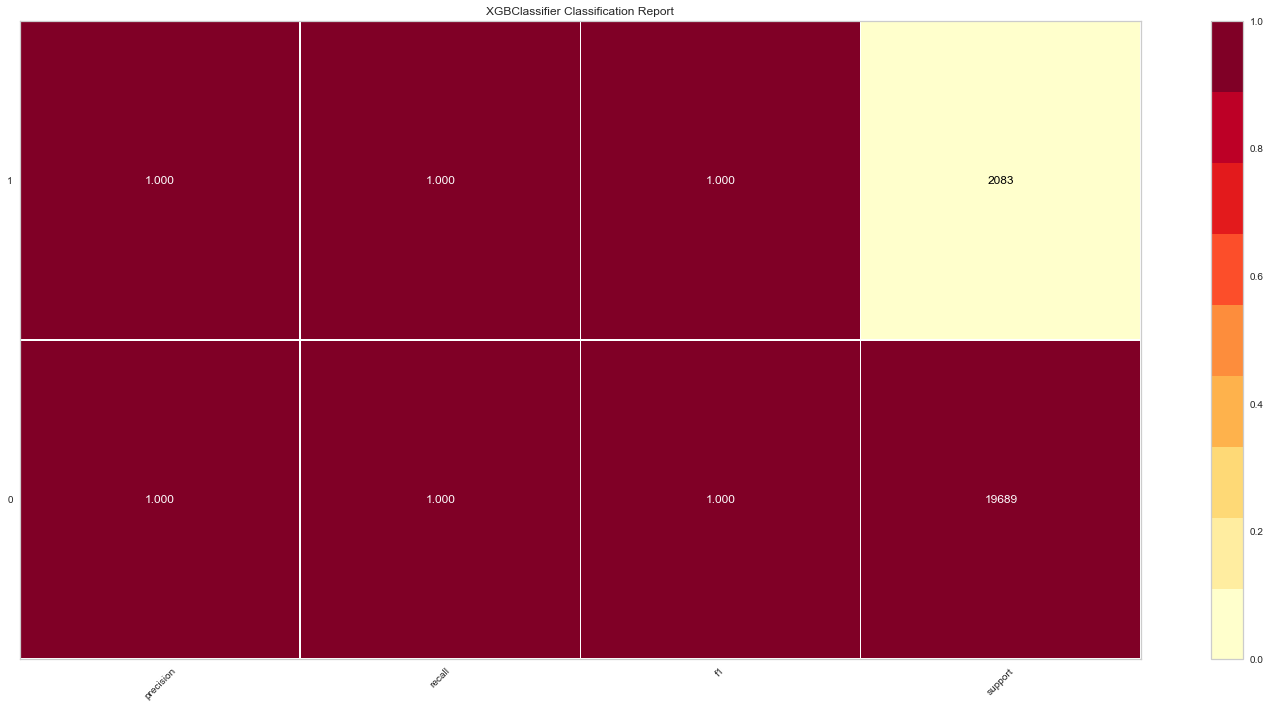

time: 3.36 s


In [183]:
get_ipython().system('pip install yellowbrick')
from yellowbrick.classifier import ClassificationReport
plt.figure(figsize=(20,10))
visualizer = ClassificationReport(clf, classes=['0', '1'], support=True)
visualizer.fit(trainX, trainY) # Fit the visualizer and the model
visualizer.score(testX, testY) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

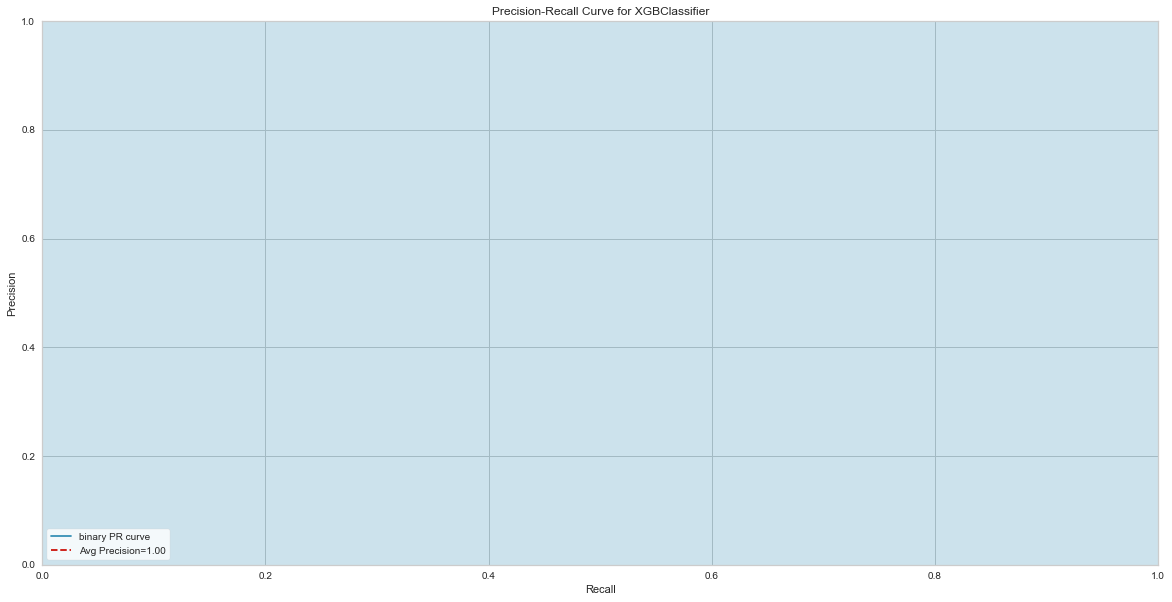

time: 287 ms


In [184]:
from yellowbrick.classifier import PrecisionRecallCurve
plt.figure(figsize=(20,10))
# Create the visualizer, fit, score, and poof it
viz = PrecisionRecallCurve(clf, classes=['0', '1'], support=True)
viz.fit(trainX, trainY)
viz.score(testX, testY)
viz.poof()



# Models 2, 3, 4, 5: SVM, KNN, LOG, DTC

copied from: https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets
## Log, KNN, SVM, Decsion tree models
## uses gridsearch to find best parameters


In [204]:
# re-split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

time: 42 ms


In [205]:
#preprocessing
from sklearn import preprocessing
X_train.head()

,new_id,device,no_actions,min_trans_diff,max_trans_diff,quote_time_diff,claim_pay_diff,mean_trans_time,total_trans_time,paid_min,paid_max,paid_mean,paid_diff,occupant_count,holder_gender,holder_age,holder_error_in_gender,occupant_error_in_gender,min_occupant_age,max_occupant_age,mean_occupant_age,mean_household_age,house_type,house_square_footage,house_number_of_bedrooms,house_number_of_floors,street,street_number,suburb,email_provider
3056,3056,1,2,818.97,818.97,818.97,0.00,818.97,818.97,0.00,0.00,0.00,0.00,5.00,1,38.00,0,0.50,10,38,21.50,24.80,1.00,331.19,1.00,1.00,50,83.00,446,96875
106682,402905,2,5,0.00,9799.69,440.00,0.00,2589.97,10359.86,0.00,0.00,0.00,0.00,1.00,1,32.00,1,0.00,0,0,0.00,32.00,1.00,292.11,3.00,1.00,58,113.00,308,96875
34038,34038,3,2,173.60,173.60,173.60,0.00,173.60,173.60,0.00,0.00,0.00,0.00,7.00,1,31.00,0,0.83,12,38,27.33,27.86,0.00,251.35,3.00,1.00,9,102.00,248,96875
53300,53300,1,3,93.56,697.04,697.04,0.00,395.30,790.60,0.00,0.00,0.00,0.00,4.00,1,39.00,1,0.33,5,42,21.33,25.75,1.00,285.66,1.00,1.00,48,88.00,12,96875
36412,36412,2,10,91.74,7321805.47,916.16,7321805.47,1418707.35,12768366.16,8012.69,8012.69,8012.69,0.00,9.00,0,54.00,1,0.62,10,57,35.12,37.22,0.00,200.51,2.00,1.00,42,50.00,123,39602


time: 12 ms


In [201]:
X_train = preprocessing.MinMaxScaler().fit_transform(X_train)
X_test = preprocessing.MinMaxScaler().fit_transform(X_test)
#y_train = preprocessing.MinMaxScaler().fit_transform(y_train)
#y_test = preprocessing.MinMaxScaler().fit_transform(y_test)


time: 50 ms


In [189]:
"""X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)
X_test"""


'X_train = preprocessing.scale(X_train)\nX_test = preprocessing.scale(X_test)\nX_test'

time: 1 ms


In [202]:
# Turn the values into an array for feeding the classification algorithms.
# X_train = X_train.values
# X_test = X_test.values
y_train = y_train.values
y_test = y_test.values


time: 1e+03 µs


In [208]:
# Let's implement simple classifiers
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score

time: 1 ms


In [210]:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=2)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")


Classifiers:  LogisticRegression Has a training score of 99.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 100.0 % accuracy score
Classifiers:  SVC Has a training score of 90.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 100.0 % accuracy score
time: 1min 56s


In [ ]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV

# Logistic Regression
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_


In [ ]:
"""knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_"""


In [ ]:
# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
# SVC best estimator
svc = grid_svc.best_estimator_


In [ ]:
# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),
"min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
# tree best estimator
tree_clf = grid_tree.best_estimator_



# SMOTE Technique (Over-Sampling)
## copied from: https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets
## SMOTE stands for Synthetic Minority Over-sampling Technique.
## <img src=SMOTE_R_visualisation_3.png, width=400>
## https://raw.githubusercontent.com/rikunert/SMOTE_visualisation/master/SMOTE_R_visualisation_3.png

Unlike Random UnderSampling, SMOTE creates new synthetic points in order to have an equal balance of the classes. This is a way for solving the "class imbalance problems".




In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))
# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

In [ ]:
# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


In [ ]:
# Implementing SMOTE Technique
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
best_est = rand_log_reg.best_estimator_
prediction = best_est.predict(original_Xtrain[test])
accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
precision_lst.append(precision_score(original_ytrain[test], prediction))
recall_lst.append(recall_score(original_ytrain[test], prediction))
f1_lst.append(f1_score(original_ytrain[test], prediction))
auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)


In [ ]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))
y_score = best_est.decision_function(original_Xtest)


In [ ]:
average_precision = average_precision_score(original_ytest, y_score)
print('Average precision-recall score: {0:0.2f}'.format(
average_precision))

In [ ]:
from sklearn.metrics import precision_recall_curve
fig = plt.figure(figsize=(12,6))
precision, recall, _ = precision_recall_curve(original_ytest, y_score)
plt.step(recall, precision, color='r', alpha=0.2,
where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
color='#F59B00')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
average_precision), fontsize=16)

In [ ]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)
# This will be the data were we are going to
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)
# We Improve the score by 2% points approximately
# Implement GridSearchCV and the other models.
# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))


In [ ]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique

y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling

#y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)
log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
#kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)
fig, ax = plt.subplots(2, 2,figsize=(22,12))

sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)
"""sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)"""
sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)

In [ ]:
x[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)
sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))
"""print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))"""
print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))
print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

In [ ]:
get_ipython().system('pip install yellowbrick')
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(LogisticRegression(), classes=['0', '1'], support=True)
visualizer.fit(X_train, y_train) # Fit the visualizer and the model
visualizer.score(X_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data
visualizer = ClassificationReport(SVC(), classes=['0', '1'], support=True)
visualizer.fit(X_train, y_train) # Fit the visualizer and the model
visualizer.score(X_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data
visualizer = ClassificationReport(DecisionTreeClassifier(), classes=['0', '1'], support=True)
visualizer.fit(X_train, y_train) # Fit the visualizer and the model
visualizer.score(X_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data
visualizer = ClassificationReport(KNeighborsClassifier(), classes=['0', '1'], support=True)
visualizer.fit(X_train, y_train) # Fit the visualizer and the model
visualizer.score(X_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

In [ ]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score
# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)
# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)
d = {'Technique': ['Oversampling (SMOTE)'], 'Score': [oversample_score]}
final_df = pd.DataFrame(data=d)
# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)
# Note how high is accuracy score it can be misleading!
final_df

In [ ]:
from yellowbrick.classifier import ROCAUC
f, (ax1) = plt.subplots(1, 1, figsize=(12,10))
# Instantiate the visualizer with the classification model
visualizer = ROCAUC(LogisticRegression(), classes=['0', '1'])
visualizer.fit(X_train, y_train) # Fit the training data to the visualizer
visualizer.score(X_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

In [ ]:
from yellowbrick.classifier import PrecisionRecallCurve
f, (ax1) = plt.subplots(1, 1, figsize=(12,10))
# Create the visualizer, fit, score, and poof it
viz = PrecisionRecallCurve(LogisticRegression(), classes=['0', '1'])
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

In [ ]:
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import DiscriminationThreshold
f, (ax1) = plt.subplots(1, 1, figsize=(12,10))
# Instantiate the classification model and visualizer
logistic = LogisticRegression()
visualizer = DiscriminationThreshold(logistic)
visualizer.fit(X_train, y_train) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

# undersampling with KNN

In [ ]:
## modelling pacakges
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from scipy.stats import norm

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.under_sampling import NearMiss

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,recall_score,precision_recall_curve,average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import balanced_accuracy_score

from sklearn.utils import resample

In [ ]:
# heavily skewed towards non fraud
print('No Frauds', data['fraud'].value_counts()[0], round(data['fraud'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Frauds', data['fraud'].value_counts()[1], round(data['fraud'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

In [ ]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('fraud', data = data, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

## imbalanced data

As we can see the data is imbalanced, 98% of the data is non-fraud, while 2% of the data is fraud. Thus setting all the values in the data to 0 will yield high score, but this will lead to a large amount of false negatives. (below)

Steps:
1. separate data into test and training (train on undersampled data)
2. run models on data, using cross validation

In [ ]:
# Separate input features and target
y = data.fraud
X = data.drop('fraud', axis=1)

# setting up testing and training sets, splitting by 20/80 testing/training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

In [ ]:
# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

# checking accuracy
print('Test score: ', accuracy_score(y_test, dummy_pred))

# Checking unique values
predictionsDummy = pd.DataFrame(dummy_pred)
predictionsDummy[0].value_counts()

# scoring 0.98344

In [ ]:
# Modeling the data as is
# Train model
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
 
# Predict on training set
lr_pred = lr.predict(X_test)

# Checking accuracy
print(accuracy_score(y_test, lr_pred))
#0.98346

# Checking unique values
predictions = pd.DataFrame(lr_pred)
predictions[0].value_counts()

# 5 frauds
# note we also get a convergance warning 

In [ ]:
# using sklearn class_weight balanced parameter to try to balance the imbalance in data
# also applying the better accuracy scores F1 score, recall score, AUC score
logistic = LogisticRegression(class_weight='balanced')
model = logistic.fit(X_train, y_train)

logisticPred = model.predict(X_test)

print(accuracy_score(y_test, logisticPred))

predictionslog = pd.DataFrame(logisticPred)
predictionslog[0].value_counts()
# accuracy = 0.977796
# fraud 4905

In [ ]:
# train model
rfc = RandomForestClassifier(class_weight='balanced', n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

print(accuracy_score(y_test, rfc_pred))

predictionsRFC = pd.DataFrame(rfc_pred)
predictionsRFC[0].value_counts()

In [ ]:
# dropping useless columns
data.drop(['paid_min','paid_max', 'paid_mean','paid_diff'], axis = 1)

In [ ]:
# Separate input features and target
Y = data1.fraud
X = data1.drop(['fraud'], axis=1)

# setting up testing and training sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=2727)

# concatenate our training data back together
X = pd.concat([X_train, Y_train], axis=1)

In [ ]:
# separate minority and majority classes
not_fraud = data1[data1.fraud==0]
fraud = data1[data1.fraud==1]

In [ ]:
len(not_fraud)

In [ ]:
len(fraud)

In [ ]:

not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

In [ ]:
# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.fraud.value_counts()

In [ ]:
Y_test.value_counts()

In [ ]:

# trying logistic regression with the balanced dataset
y_train = downsampled.fraud
X_train = downsampled.drop('fraud', axis=1)

underSampledLog = LogisticRegression(solver='liblinear')
underSampledLog.fit(X_train, y_train)



In [ ]:
len(y_train)

In [ ]:
log_reg_pred = cross_val_predict(underSampledLog, X_train, y_train, cv=5,
                             method="decision_function")

In [ ]:
print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))

In [ ]:
# Predict on test
undersampled_pred = log_reg_pred.predict(X_test)
# predict probabilities
probs = log_reg_pred.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]

In [ ]:
# f1 score
f1_under = f1_score(Y_test, undersampled_pred)
print("F1 Score is {:.2f}".format(f1_under))

In [ ]:
b_score = balanced_accuracy_score(Y_test, undersampled_pred)
b_score

In [ ]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, probs)
# calculate precision-recall AUC
auc_under = auc(recall, precision)
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')
plt.title("Precison-Recall Curve for Logistic with AUC score: {:.3f}".format(auc_under))
# show the plot
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
#l_precision, l_recall, l_threshold = precision_recall_curve(, )

In [ ]:
def graph_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve(log_fpr, log_tpr)
plt.show()

In [ ]:
# assign cnf_matrix with result of confusion_matrix array
cnf_matrix = confusion_matrix(Y_test,undersampled_pred)
#create a heat map
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'Blues', fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [ ]:
## we see that while the undersampled logistic regression is good for insample training, out of sample it performs relatively poorly as it detects a lot of false positives